## Twilight NEO simulations

Illustrating some specifics about the twilight NEO scheduler simulations.

In [1]:
# Import basic useful packages
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import healpy as hp

In [2]:
import rubin_sim.maf as maf

### Basic information on the twilight NEO family

This gives us the high-level stored information on the twilight NEO family, as well as the pre-calculated summary metric values. Further down, we will calculate some targeted metrics to check out the twilight NEO visits specifically, as well as things that may be relevant for this family only.

---
**twilight neo 15s** : This microsurvey family is an update of the v2.0 twilight NEO microsurvey. The visits in the v2.0 simulations were 1s long; here they are updated to 15s long, so that the shutter is moving within the camera team specified requirements. The change also leads to a boost in NEO discoveries so should be considered a replacement for the v2.0 twilight NEO microsurvey. The additional visits here are low-solar elongation, high airmass 15s visits during morning and evening twilight.   
**version**: 2.2  
**runs**:  


(<Figure size 1000x600 with 1 Axes>, <AxesSubplot: >)

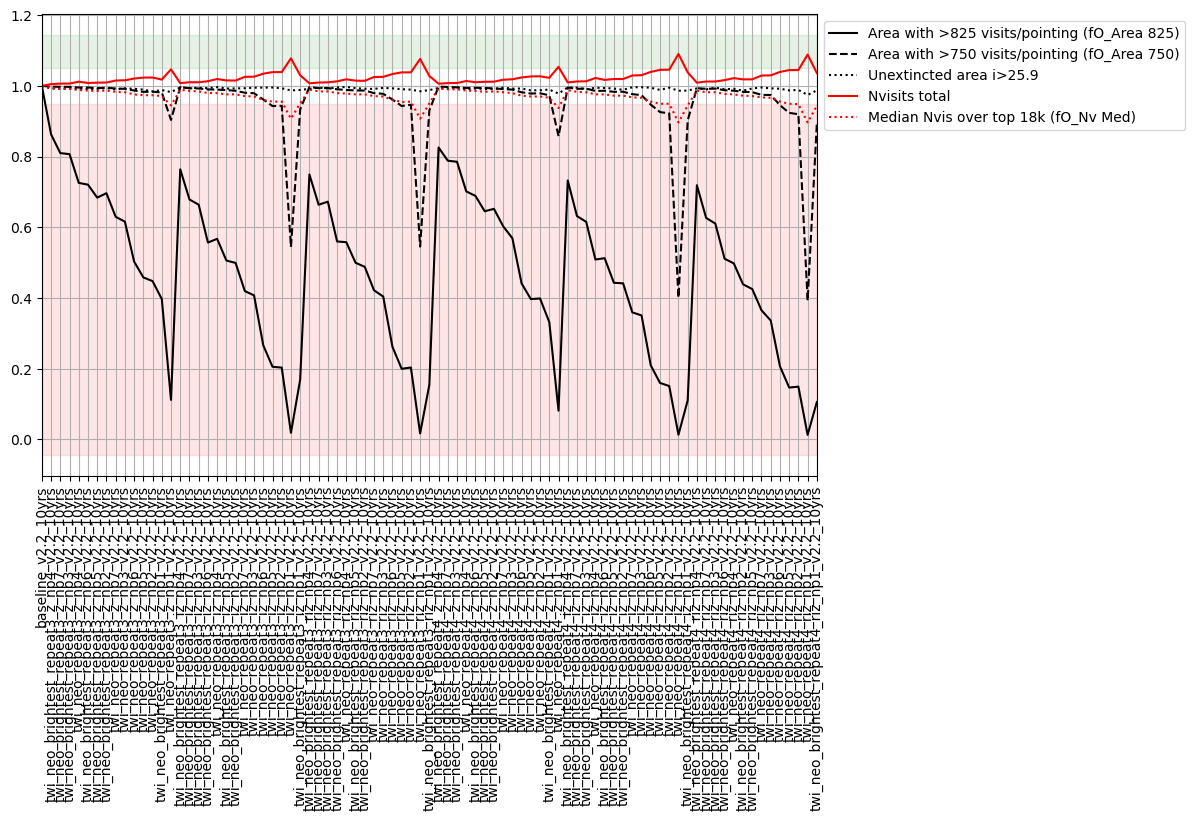

In [49]:
families = maf.archive.get_family_descriptions('runs_v2.2.json')
family_list = families.index.values
summary_source = 'summary_2022_10_25.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metrics_source = 'metric_sets.json'
metric_sets = maf.get_metric_sets(metrics_source)

baseline_run = 'baseline_v2.2_10yrs'
these_runs = np.concatenate([[baseline_run], families.explode('run').loc['twilight neo 15s']['run']])

maf.describe_families(families.loc[['twilight neo 15s']],
                      summary=summaries,
                     table_metric_set=metric_sets.loc['short description'],
                     plot_metric_set=metric_sets.loc['plot areas'],
                     baseline_run=baseline_run)

Generally speaking, the fO_Nv Median will reflect the overall effect of the additional time required for the twilight NEO visits. fO_Nv discounts shorts exposures when counting 'visits' -- and the balance of the remainder of the survey should be staying about the same as more time is taken for visits during twilight.  Note that the overall 'Nvisits total' *does* include short visits, so you can see how the ratio between Nvisits total and fO_Nv Median changes as the number of short exposure time visits increases. 

This lets you generate an approximation of "expected impact on metrics which scale with WFD visits", as well as gives some insight on the total number of twilight NEO visits. 

In [4]:
# Connect to the databases.
rootDir = '/astro/store/pogo4/opsim/fbs_db/fbs_2.2'
rootDir = '/Users/lynnej/opsim/v2.2/'

runs = ['baseline_v2.2_10yrs', 
        'twi_neo_repeat4_riz_np4_v2.2_10yrs',
       'twi_neo_brightest_repeat4_riz_np4_v2.2_10yrs']
opsdb = {}
for r in runs:
    opsdb[r] = os.path.join(rootDir, r + '.db')

In [5]:
rerun = False
outDir = 'twilight_neo'

In [6]:
# Pull out some of the data once .. in case we just want to make histograms. 
# We can also use it later for metrics though! 
simdata = {}
cols = ['observationStartMJD', 'observationStartLST', 
        'night', 'filter', 'fiveSigmaDepth', 'fieldRA', 'fieldDec', 'rotSkyPos',
        'solarElong', 'altitude', 'seeingFwhmEff', 'skyBrightness', 
        'visitExposureTime', 'numExposures', 'airmass',]
constraint = 'note="twilight_neo"'
metadata = 'twiNeo'
satStacker = maf.SaturationStacker()
haStacker = maf.HourAngleStacker()
normXStacker = maf.NormAirmassStacker()
twilights = [r for r in runs if r.startswith('twi_neo')]
for r in twilights:
    simdata[r] = maf.getSimData(opsdb[r], constraint, cols,
                                stackers=[satStacker, haStacker, normXStacker])

In [7]:
morning = {}
evening = {}
for r in twilights:
    evening[r] = np.where(simdata[r]['HA'] > 0)[0]
    morning[r] = np.where(simdata[r]['HA'] < 0)[0]

### Distribution of various parameters for twilight NEO visits

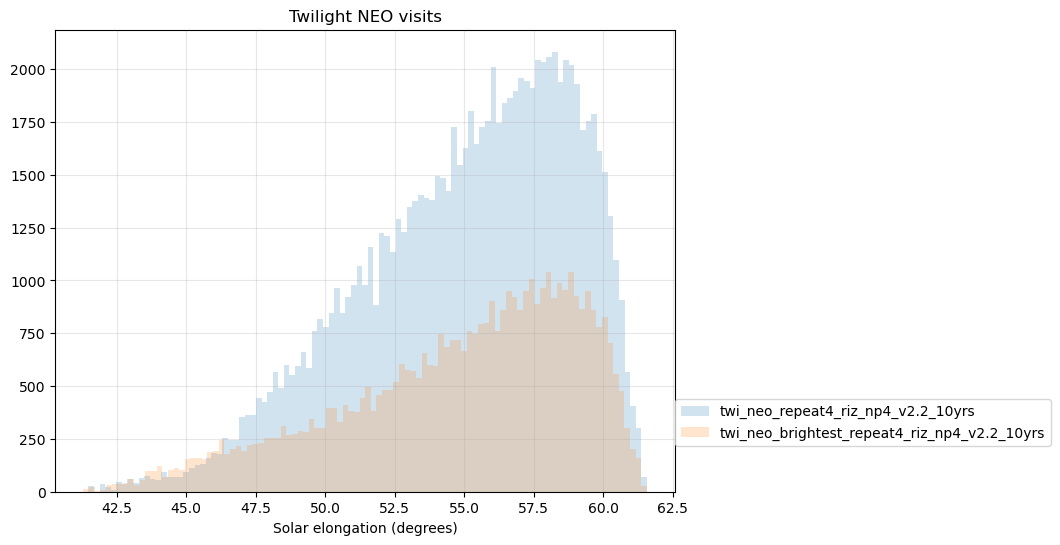

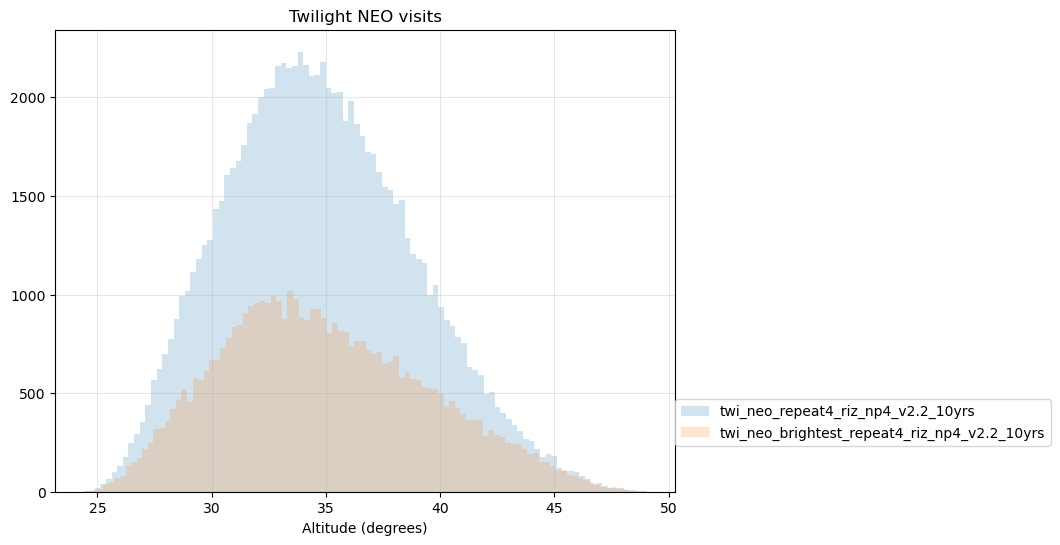

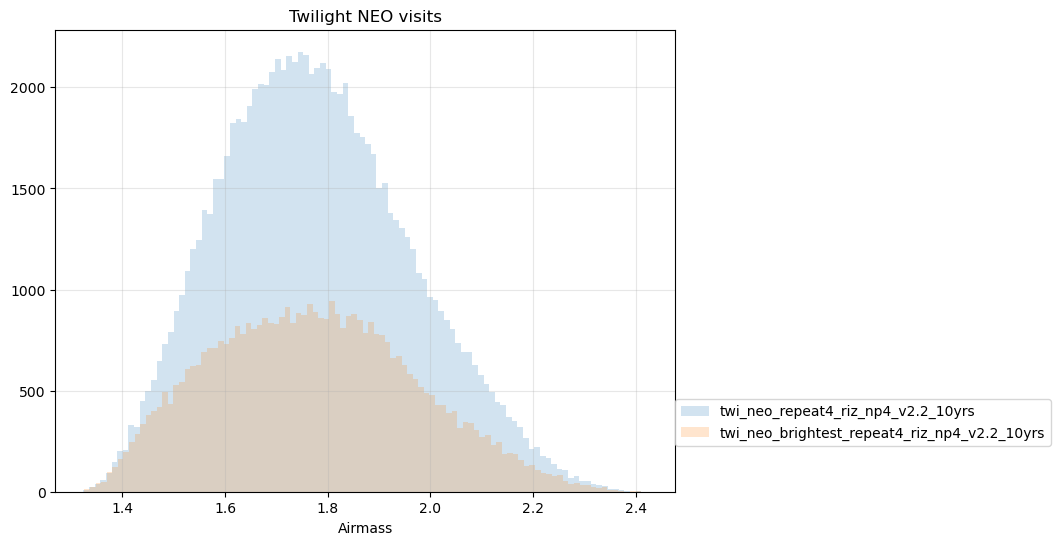

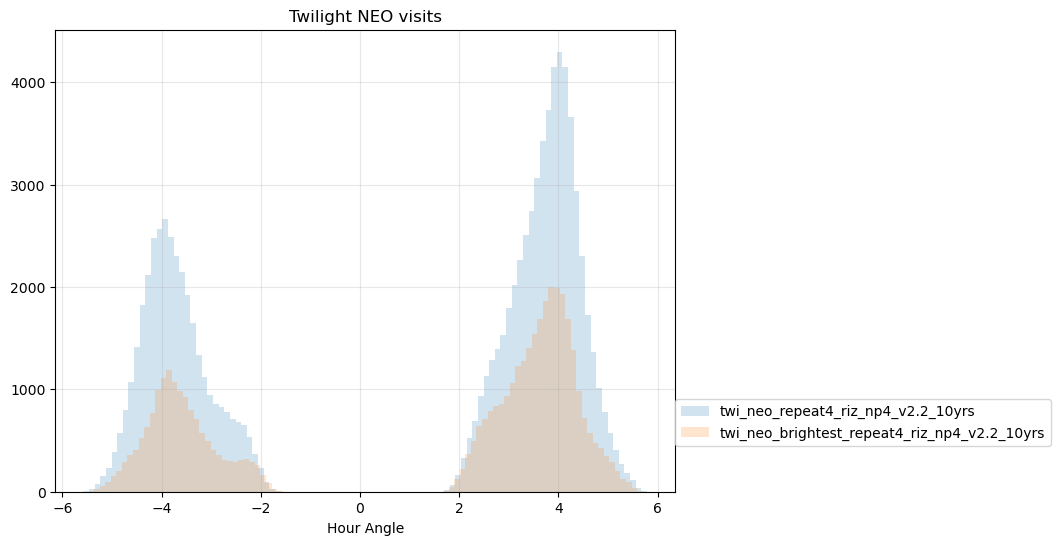

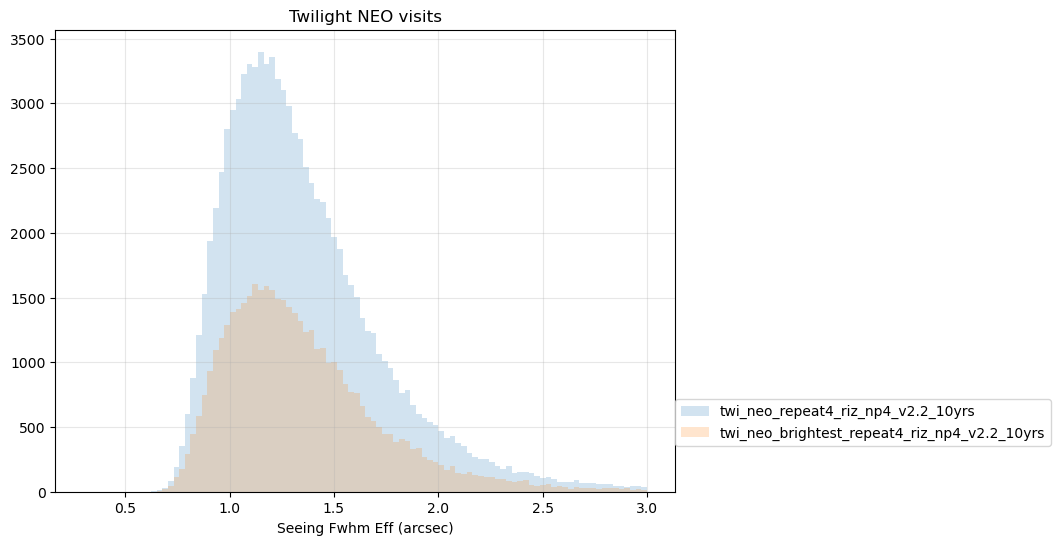

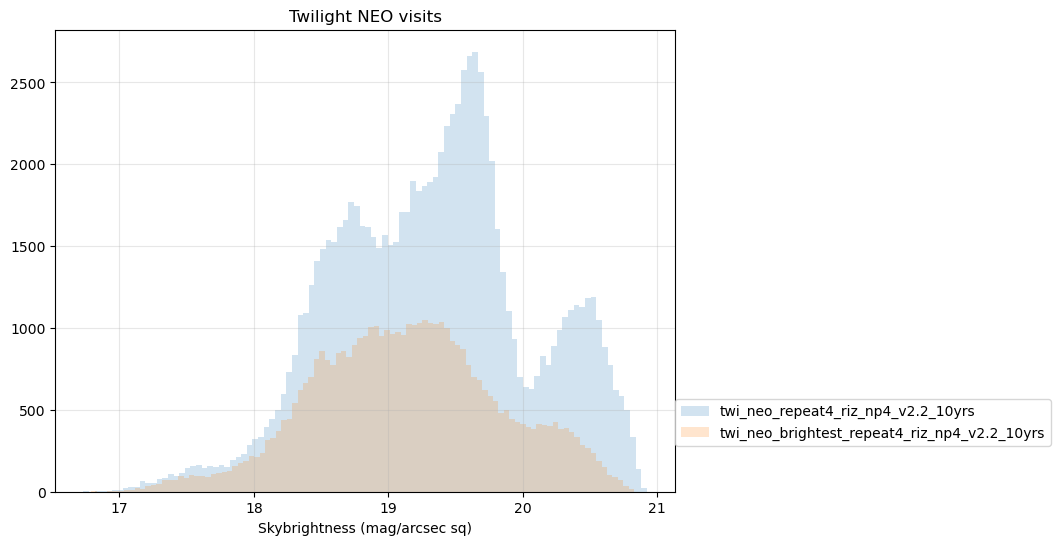

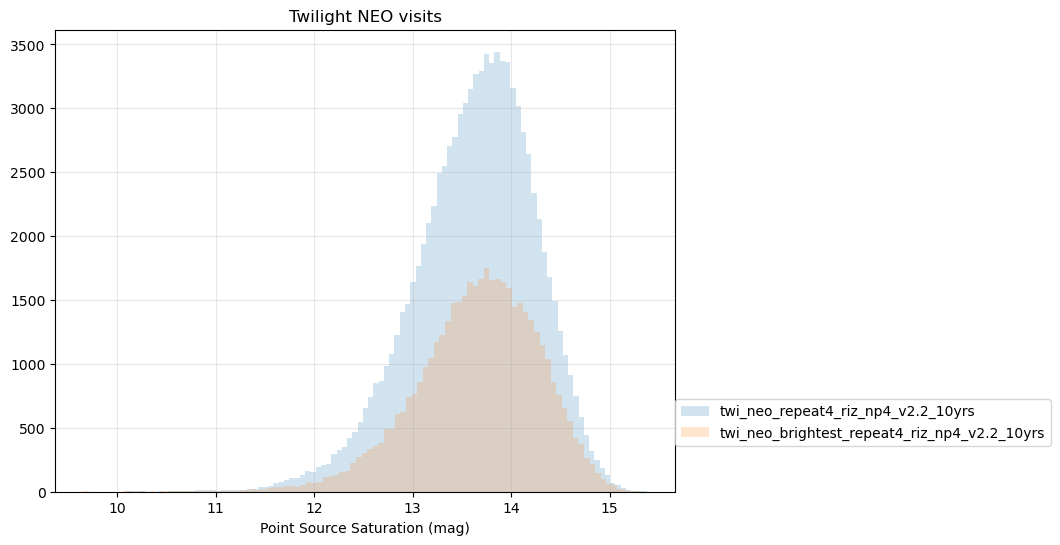

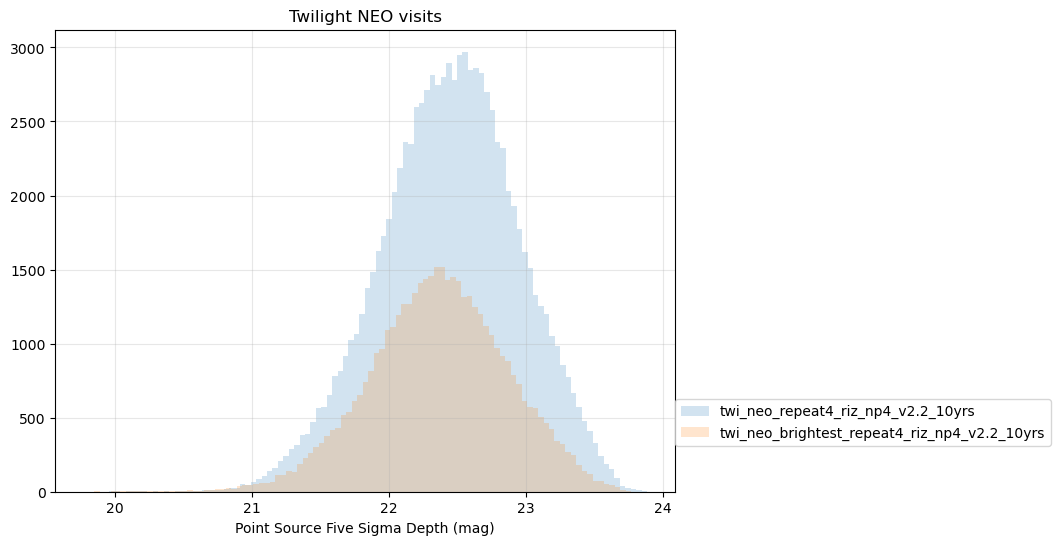

In [8]:
k = ['solarElong', 'altitude', 'airmass', 'HA', 'seeingFwhmEff', 'skyBrightness', 'saturation_mag', 'fiveSigmaDepth']
xl = ['Solar elongation (degrees)', 'Altitude (degrees)', 'Airmass', 'Hour Angle', 'Seeing Fwhm Eff (arcsec)', 
     'Skybrightness (mag/arcsec sq)', 'Point Source Saturation (mag)', 'Point Source Five Sigma Depth (mag)']

for ki, xli in zip(k, xl):
    plt.figure(figsize=(8, 6))
    if ki == 'seeingFwhmEff':
        range = [0.3, 3.0]
    else:
        range = None
    for r in twilights:
        n,b,p = plt.hist(simdata[r][ki], bins=100, alpha=0.2, range=range, label=r)
    plt.legend(loc=(1.0, 0.1), fancybox=True)
    plt.grid(True, alpha=0.3)
    plt.xlabel(xli)
    plt.title('Twilight NEO visits')

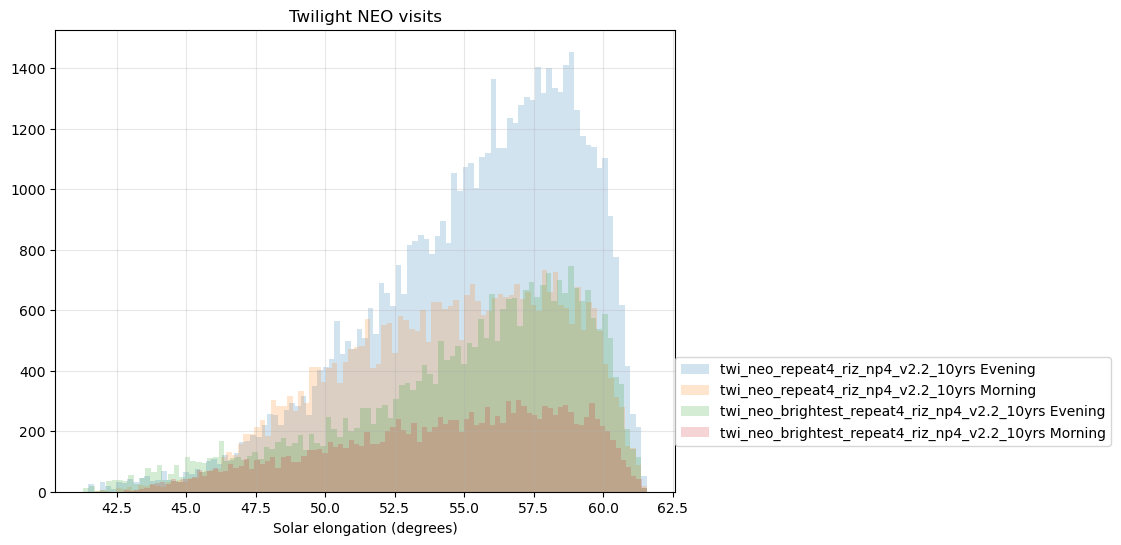

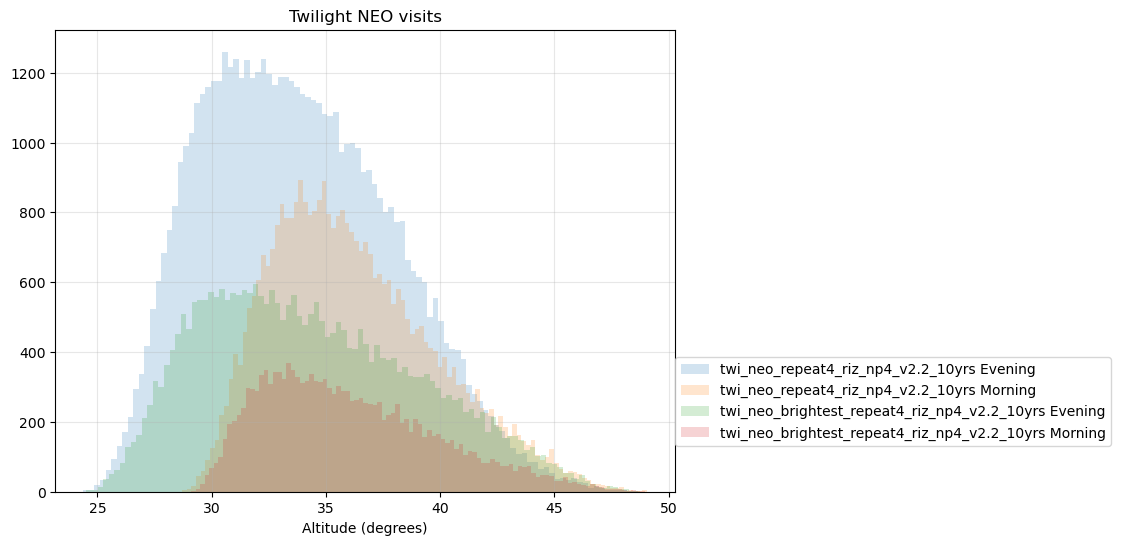

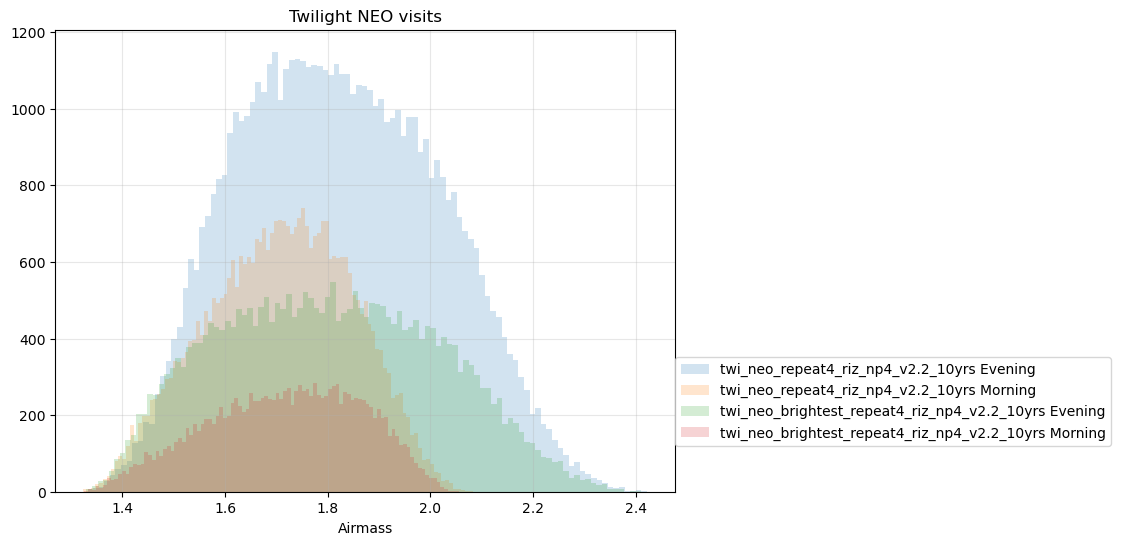

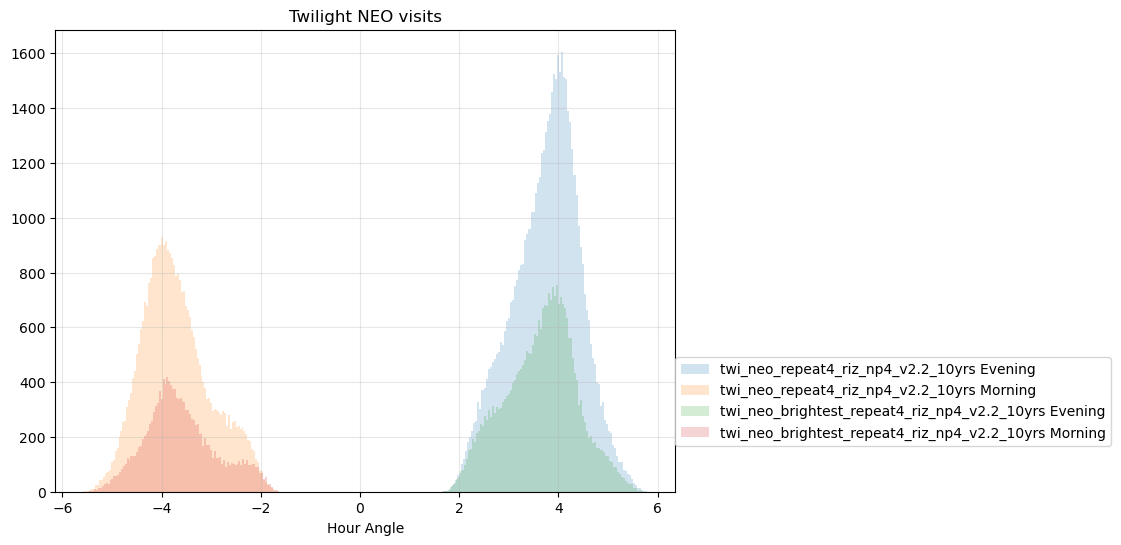

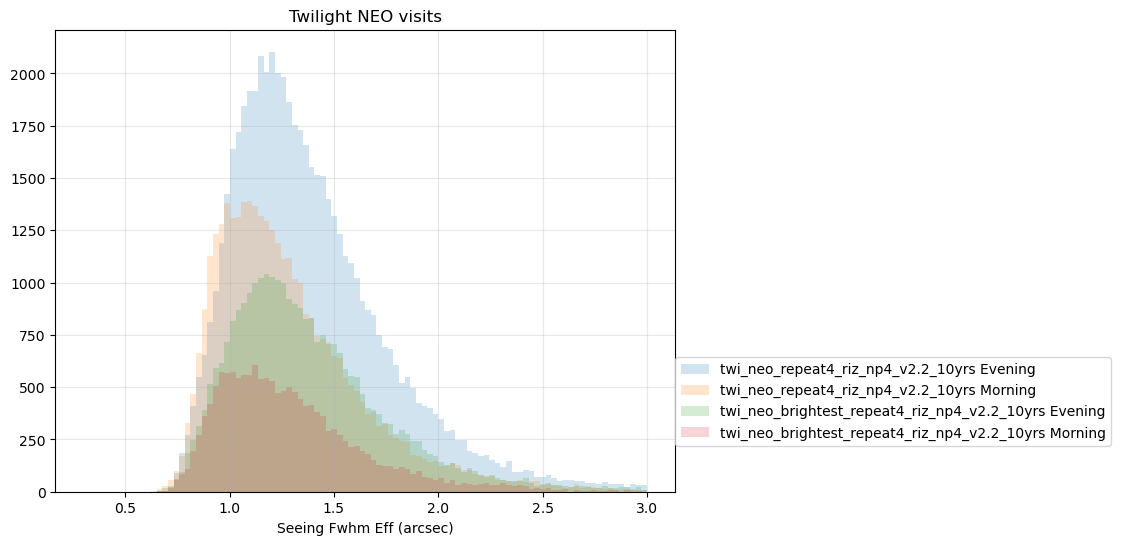

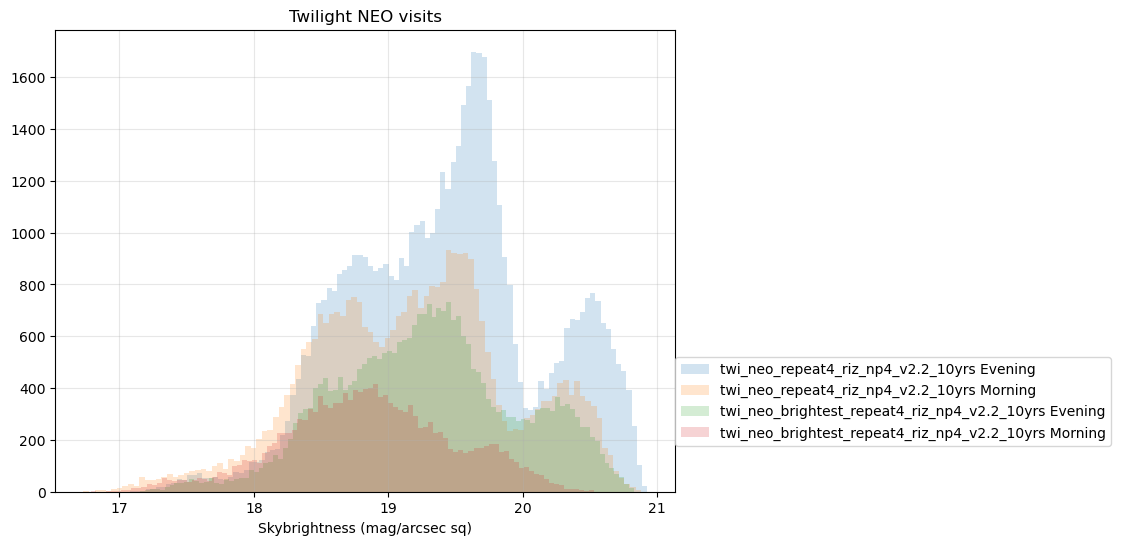

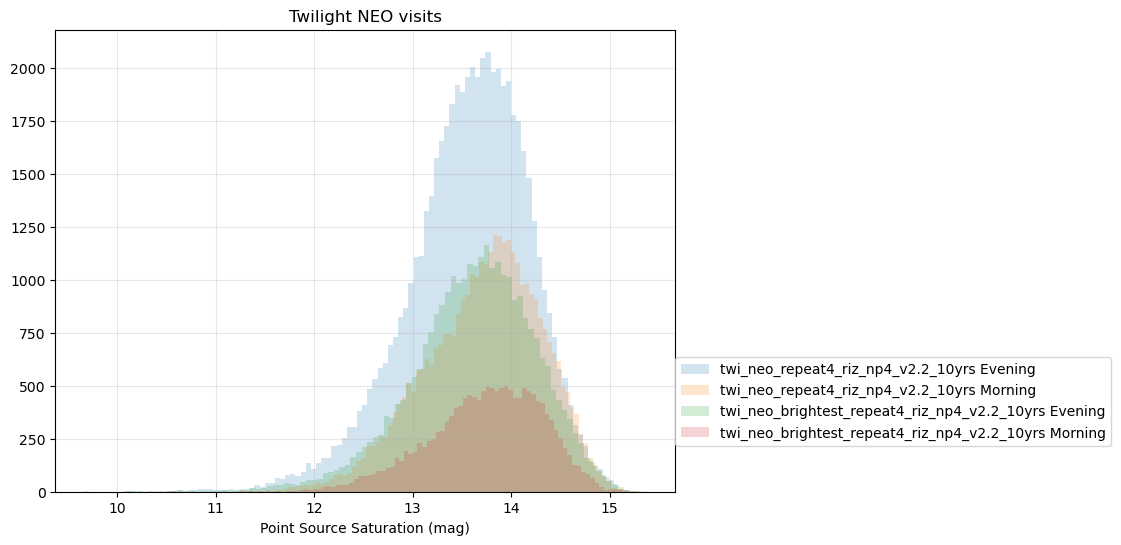

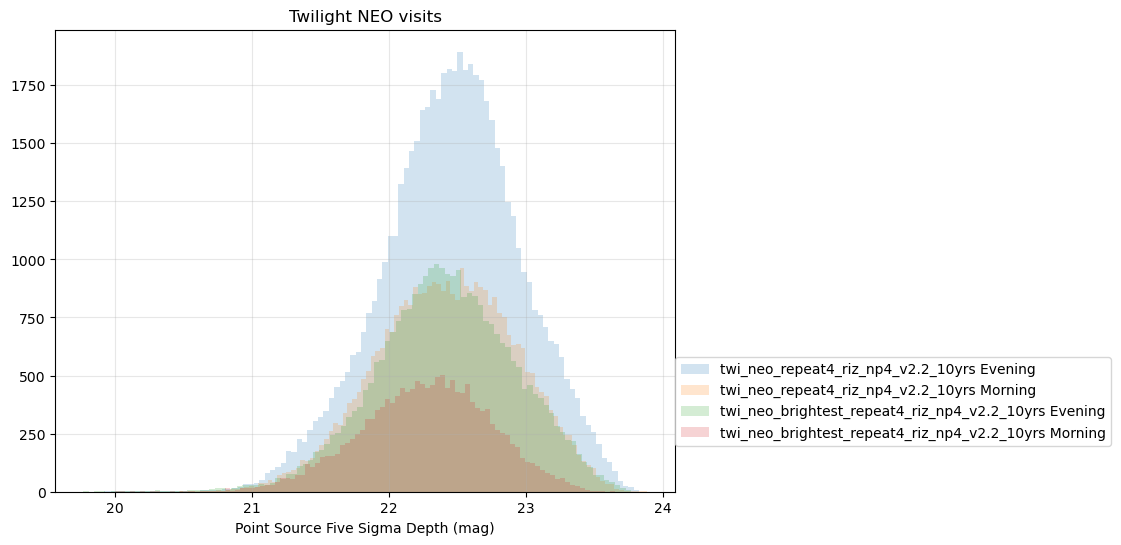

In [9]:
for ki, xli in zip(k, xl):
    plt.figure(figsize=(8, 6))
    if ki == 'seeingFwhmEff':
        range = [0.3, 3.0]
    else:
        range = None
    for r in [twilights[0], twilights[-1]]:
        n,b,p = plt.hist(simdata[r][ki][evening[r]], bins=100, alpha=0.2, range=range, label=r + ' Evening')
        n,b,p = plt.hist(simdata[r][ki][morning[r]], bins=100, alpha=0.2, range=range, label=r + ' Morning')
    plt.legend(loc=(1.0, 0.1), fancybox=True)
    plt.grid(True, alpha=0.3)
    plt.xlabel(xli)
    plt.title('Twilight NEO visits')

### Distribution of visits on the sky

In [10]:
ph = maf.PlotHandler(outDir=outDir, savefig=True, figformat='png', thumbnail=False)

In [11]:
# Plot all nights 
skyplots = {}
plotFuncs = [maf.HealpixSkyMap()]
for r in twilights:
    m = maf.CountMetric(col='observationStartMJD', metricName='Nvisits')
    s = maf.HealpixSlicer(nside=64)
    # Plot all twilight neo visits
    metadata = 'Twilight NEO All'
    skyplots[r + '_all'] = maf.MetricBundle(m, s, runName=r, info_label=metadata, plotFuncs=plotFuncs)
    metadata = 'Twilight NEO Morning'
    skyplots[r + '_morn'] = maf.MetricBundle(m, s, runName=r, info_label=metadata, plotFuncs=plotFuncs)
    metadata = 'Twilight NEO Evening'
    skyplots[r + '_eve'] = maf.MetricBundle(m, s, runName=r, info_label=metadata, plotFuncs=plotFuncs)
    # Plot visits on a singlee night with >400 twilight neo visits
    nights = np.unique(simdata[r]['night'])
    nidx = np.searchsorted(simdata[r]['night'], nights)
    nvis_per_night = np.diff(nidx)
    max_obs = nvis_per_night.max()
    night = nights[np.where(nvis_per_night - max_obs - 20)[0][0]]
    metadata = f'Twilight NEO night={night}'
    skyplots[r + '_night'] = maf.MetricBundle(m, s, runName=r, info_label=metadata, plotFuncs=plotFuncs)
    if not rerun:
        d = simdata[r]
        g = maf.MetricBundleGroup({r: skyplots[r + '_all']}, opsdb[r], outDir=outDir, resultsDb=None)
        g.runCurrent('', simData=d)
        d = simdata[r][morning[r]]
        g = maf.MetricBundleGroup({r: skyplots[r + '_morn']}, opsdb[r], outDir=outDir, resultsDb=None)
        g.runCurrent('', simData=d)
        d = simdata[r][evening[r]]
        g = maf.MetricBundleGroup({r: skyplots[r + '_eve']}, opsdb[r], outDir=outDir, resultsDb=None)
        g.runCurrent('', simData=d)
        d = simdata[r][np.where(simdata[r]['night'] == night)]
        g = maf.MetricBundleGroup({r: skyplots[r + '_night']}, opsdb[r], outDir=outDir, resultsDb=None)
        g.runCurrent('', simData=d)
    if rerun:
        skyplots[r+'_all'].read(os.path.join(outDir, skyplots[r+'_all'].fileRoot + '.npz'))
        skyplots[r+'_morn'].read(os.path.join(outDir, skyplots[r+'_morn'].fileRoot + '.npz'))
        skyplots[r+'_eve'].read(os.path.join(outDir, skyplots[r+'_eve'].fileRoot + '.npz'))
        skyplots[r+'_night'].read(os.path.join(outDir, skyplots[r+'_night'].fileRoot + '.npz'))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


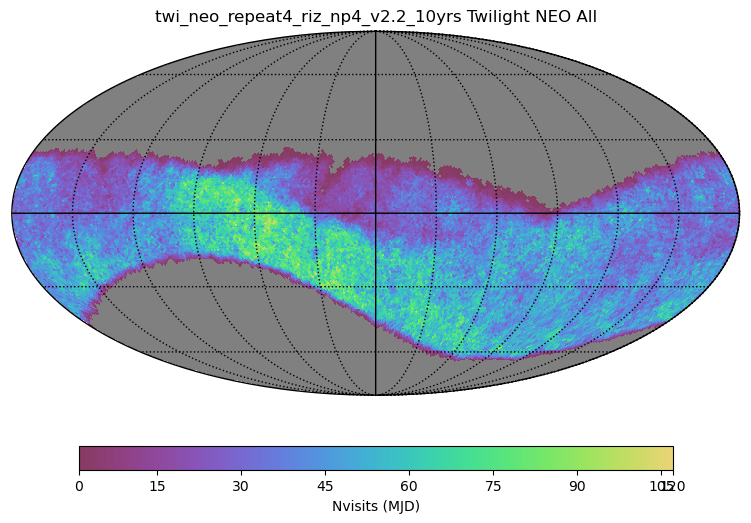

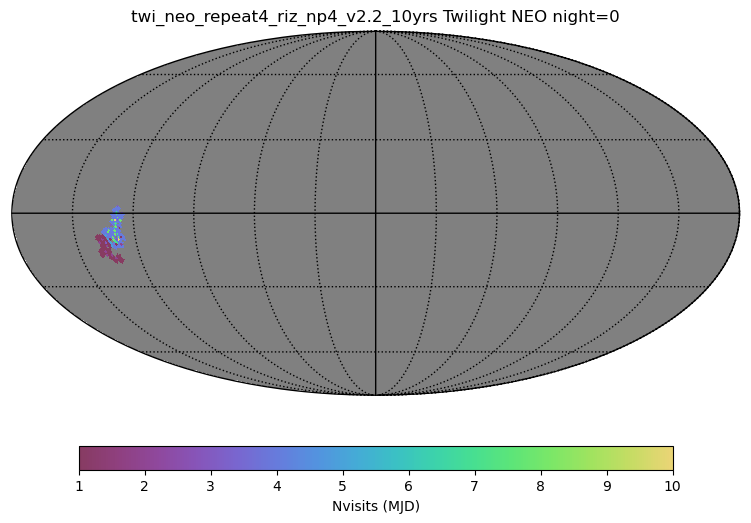

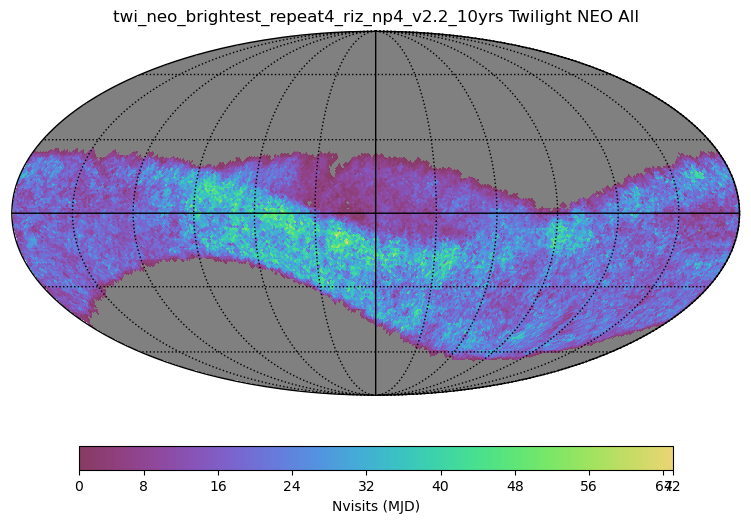

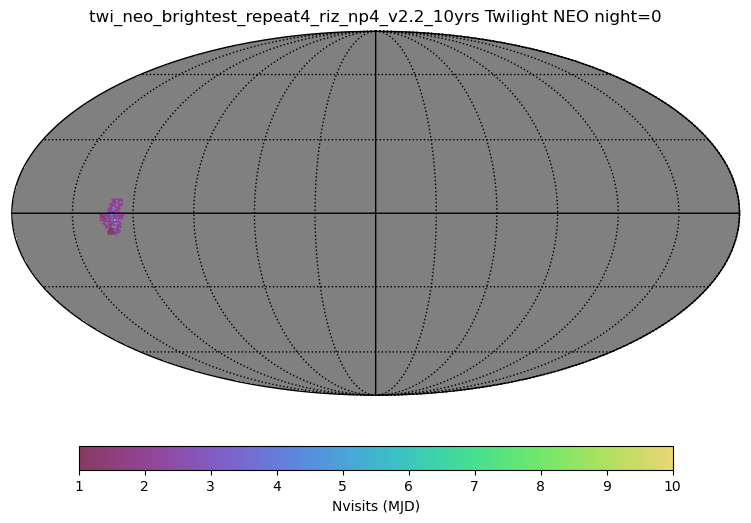

In [12]:
for r in twilights:
    skyplots[r +'_all'].setPlotDict({'title': f"{r} {skyplots[r+'_all'].info_label}", 
                                 'figsize': (8, 5)})
    skyplots[r +'_morn'].setPlotDict({'title': f"{r} {skyplots[r+'_morn'].info_label}", 
                                 'figsize': (8, 5)})
    skyplots[r +'_eve'].setPlotDict({'title': f"{r} {skyplots[r+'_eve'].info_label}", 
                                 'figsize': (8, 5)})
    skyplots[r + '_night'].setPlotDict({'title': f"{r} {skyplots[r+'_night'].info_label}",
                                       'figsize': (8,5), 'colorMax': 10})
    ph.setMetricBundles([skyplots[r+'_all']])
    ph.plot(plotFunc=maf.HealpixSkyMap())
    ph.setMetricBundles([skyplots[r+'_night']])
    ph.plot(plotFunc=maf.HealpixSkyMap())

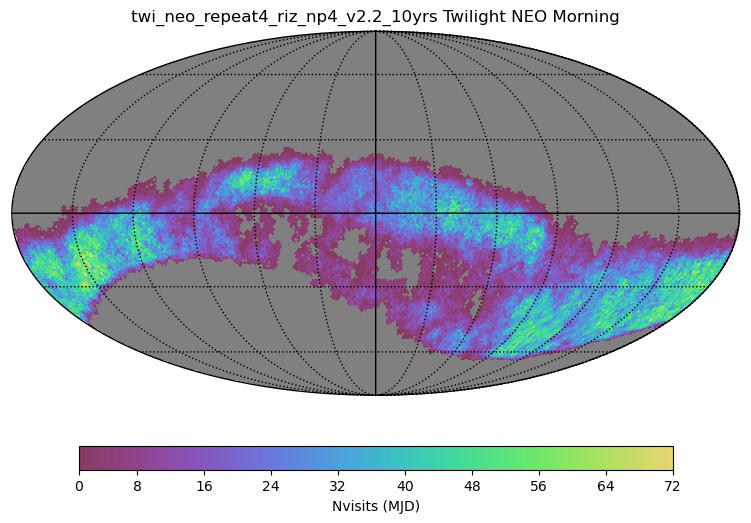

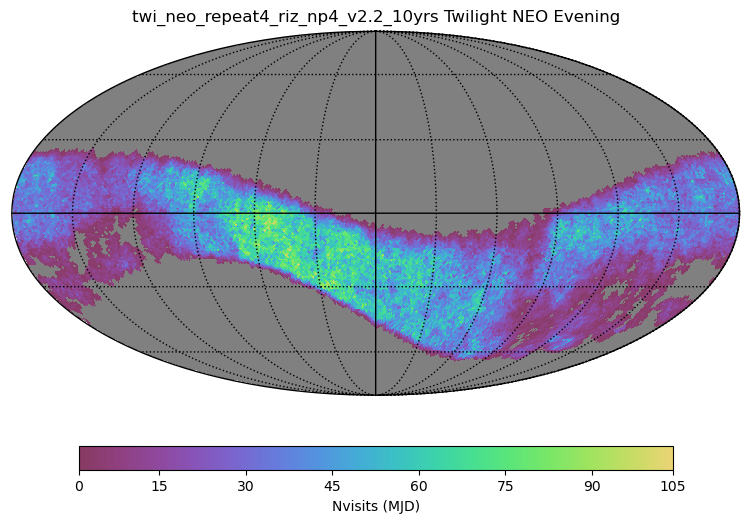

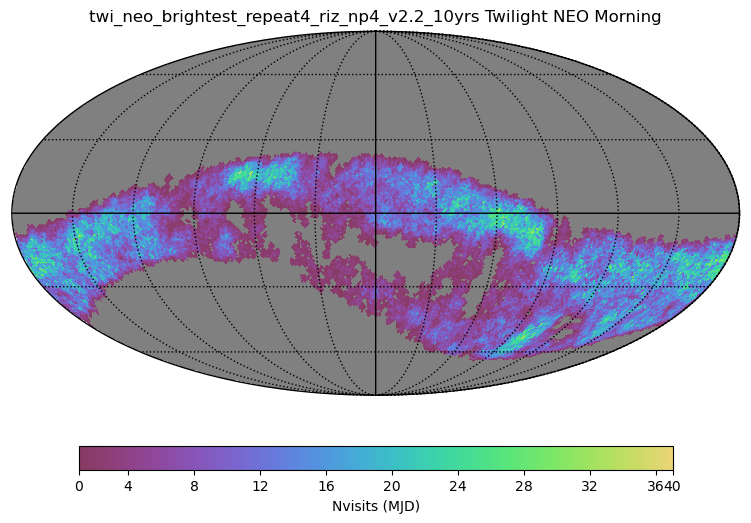

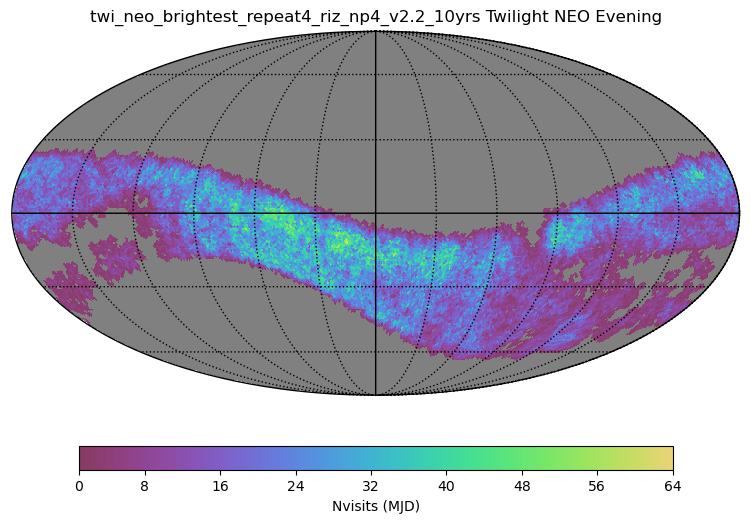

In [13]:
# Plot morning and evening twilight footprints separately
for r in twilights:
    ph.setMetricBundles([skyplots[r+'_morn']])
    ph.plot(plotFunc=maf.HealpixSkyMap())
    ph.setMetricBundles([skyplots[r+'_eve']])
    ph.plot(plotFunc=maf.HealpixSkyMap())

This footprint looks odd - however, it is the result of the solar elongation constraint combined with the altitude constraint for the telescope. A solar elongation <60 does give a smooth band across the sky; however, if the altitude constraint is added at the same time, this overall footprint results.
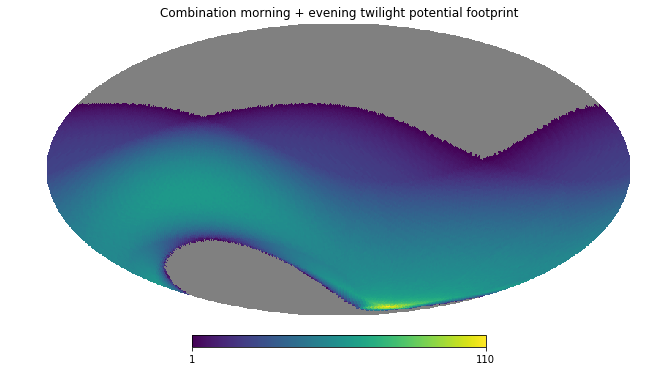

### Distribution of visits in time

In [14]:
hourglass = {}
for r in twilights:
    s = maf.HourglassSlicer()
    m = maf.HourglassMetric()
    hourglass[r] = maf.MetricBundle(m, s, None, info_label='Twilight NEO yr 1', runName=r)
    d = simdata[r][np.where(simdata[r]['night'] < 366)]
    g = maf.MetricBundleGroup({r: hourglass[r]}, opsdb[r], outDir=outDir, resultsDb=None)
    g.runCurrent('', simData=d)

In these hourglass plots, the blue line = 6 degree twilight, the yellow line = 12 degree twilight, and the red line = 18 degree twilight.  The black wavey line shows the phase of the moon. 

Visits for the twilight NEO survey *only* are shown; they are color-coded by their filter.

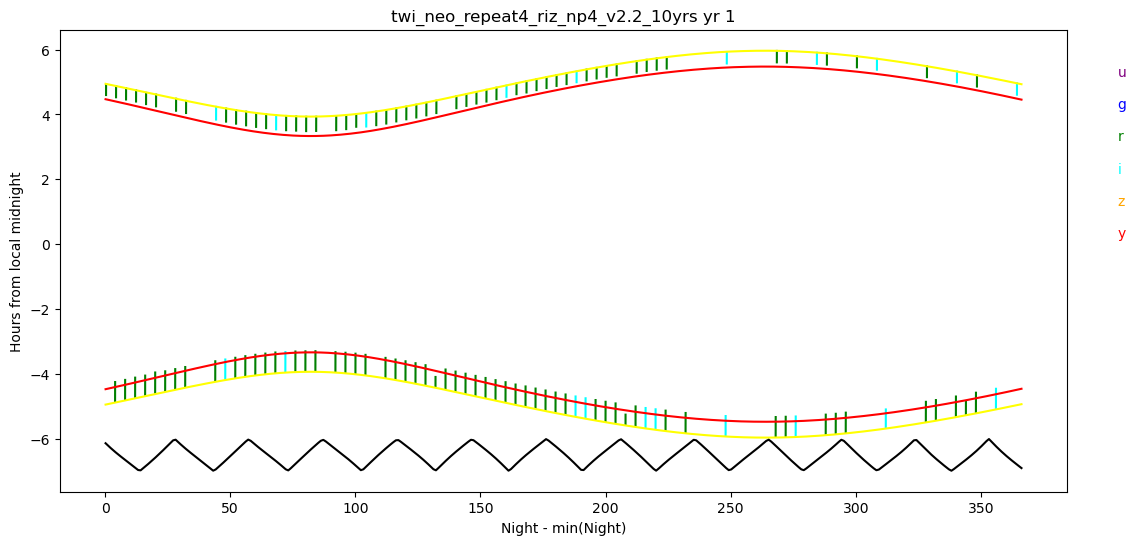

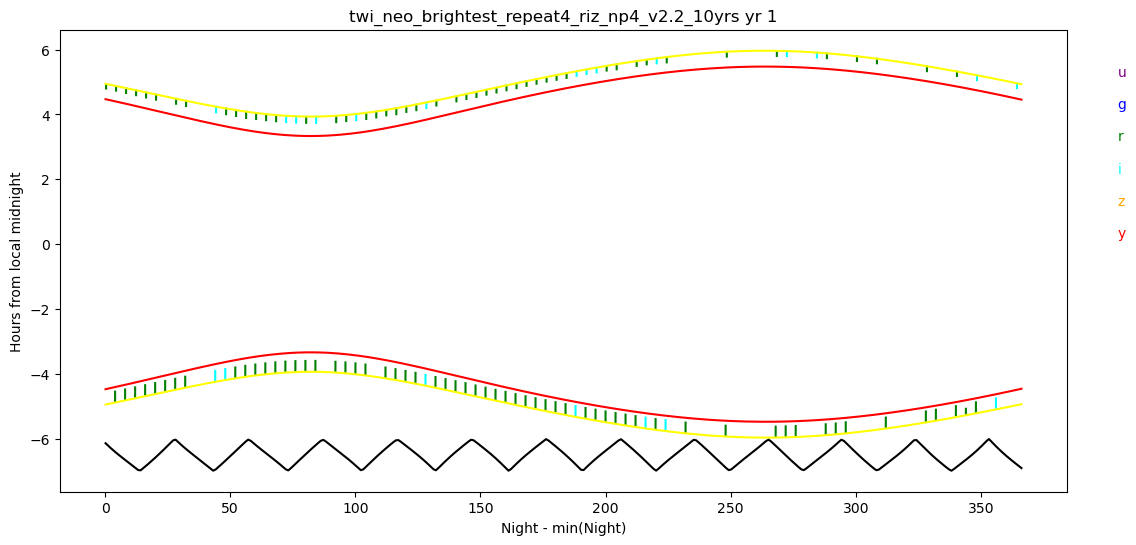

In [15]:
hourglassPlot = maf.HourglassPlot()
for r in twilights:
    fig = plt.figure(figsize=(13, 6))
    hourglassPlot(hourglass[r].metricValues, hourglass[r].slicer, {'title': f'{r} yr 1'}, fignum=fig.number)

In [18]:
m = maf.CountMetric(col='observationStartMJD', metricName='NvisitsPerNight')
s = maf.OneDSlicer(sliceColName='night', binsize=1)
summarystats = [maf.MeanMetric(), maf.MedianMetric(), maf.CountMetric(metricName='NNights'),
                maf.PercentileMetric(metricName='25th%ile', percentile=25),
                maf.PercentileMetric(metricName='75th%ile', percentile=75), 
                maf.SumMetric(metricName='Total NEOvis')]

neopernight = {}
for r in twilights:
    neopernight[r]= maf.MetricBundle(m, s, None, info_label='Twilight NEO', 
                                     runName=r, summaryMetrics=summarystats)
    g = maf.MetricBundleGroup({r: neopernight[r]}, opsdb[r], outDir=outDir, resultsDb=None)
    g.runCurrent('', simdata[r])

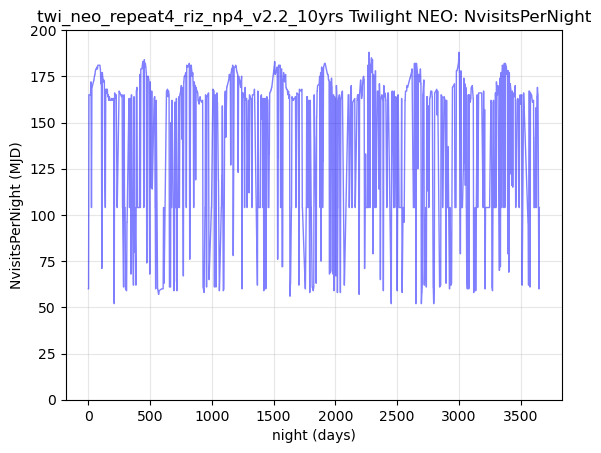

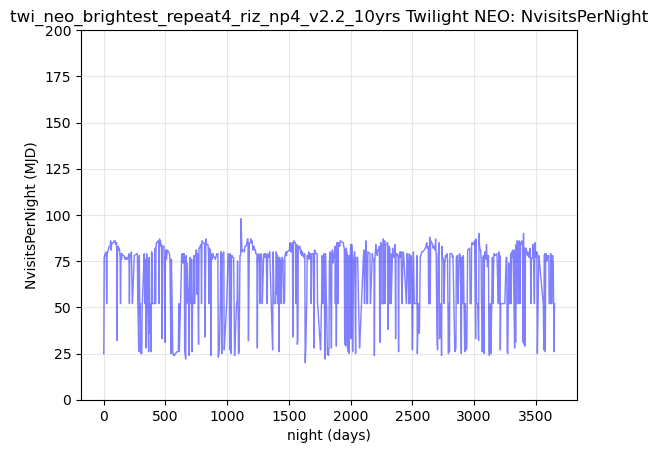

In [21]:
ph = maf.PlotHandler(outDir=outDir, savefig=True, figformat='png', thumbnail=False)
for r in twilights:
    ph.setMetricBundles([neopernight[r]])
    ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts={'yMin':0, 'yMax':200})

In [22]:
neocols = ['Mean', "Median", "NNights", "Total NEOvis"]
j = pd.DataFrame([neopernight[r].summaryValues for r in twilights], 
                 index=twilights)[neocols]
j

Mean  Median  NNights  \
twi_neo_repeat4_riz_np4_v2.2_10yrs            140.603604   164.0      666   
twi_neo_brightest_repeat4_riz_np4_v2.2_10yrs   67.594880    78.0      664   

                                              Total NEOvis  
twi_neo_repeat4_riz_np4_v2.2_10yrs                 93642.0  
twi_neo_brightest_repeat4_riz_np4_v2.2_10yrs       44883.0

### Number of Visits within a night

In [23]:
bundles = {}
countbins = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 200], int)
countbins = countbins - 0.5

for r in twilights:
    # Histogram the number of visits per night, for these twilight NEO visits.
    m = maf.NVisitsPerNightMetric(nightCol='night', bins=countbins,
                                           metricName="NVisitsPerNight")
    slicerSmall = maf.HealpixSlicer(nside=128, radius=0.75)  # Should contain only the center pointings
    slicerNormal = maf.HealpixSlicer(nside=128, radius=1.75) # Full inscribed FOV
    plotDict = {'bins': countbins, 'xlabel': 'Number of visits each night'}
    plotFunc = maf.SummaryHistogram()

    bundles[r + '_small'] = maf.MetricBundle(m, slicerSmall, None, plotDict=plotDict, runName=r, 
                                       info_label='points', plotFuncs=[plotFunc])
    bundles[r + '_normal'] = maf.MetricBundle(m, slicerNormal, None, plotDict=plotDict, runName=r, 
                                       info_label='circles', plotFuncs=[plotFunc])
    if not rerun:
        g = maf.MetricBundleGroup({r: bundles[r + '_small'], 2: bundles[r + '_normal']}, opsdb[r], 
                                 outDir=outDir, resultsDb=None)
        g.runCurrent('', simdata[r])
    if rerun:
        for k in bundles:
            bundles[k].read(os.path.join(outDir, bundles[k].fileRoot + '.npz'))

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


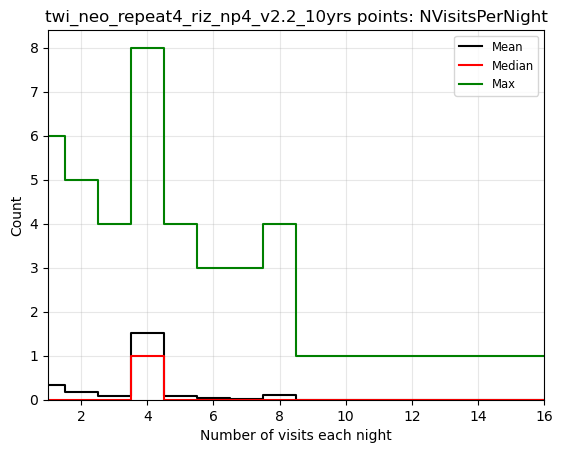

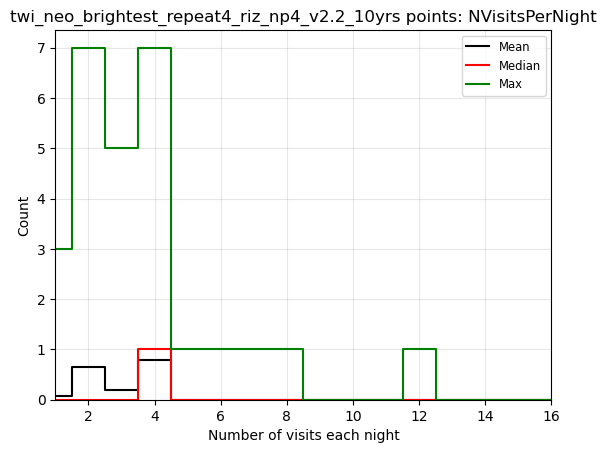

In [24]:
for r in twilights:
    bu = [bundles[r+'_small'], bundles[r+'_small'], bundles[r+'_small']]
    ph.setMetricBundles(bu)
    colors = ['k', 'b', 'c', 'g', 'y', 'r', 'm']
    plotdicts = [{'color': 'k', 'metricReduce': maf.MeanMetric(), 'label': 'Mean'},
                 {'color': 'r', 'metricReduce': maf.MedianMetric(), 'label': 'Median'},
                 {'color': 'g', 'metricReduce': maf.MaxMetric(), 'label': 'Max',
                 'legendlocal': (1.01, 0.2), 'yMin': 0, 'xMin': 1, 'xMax': 16}]
    ph.plot(plotFunc=maf.SummaryHistogram(), plotDicts=plotdicts)

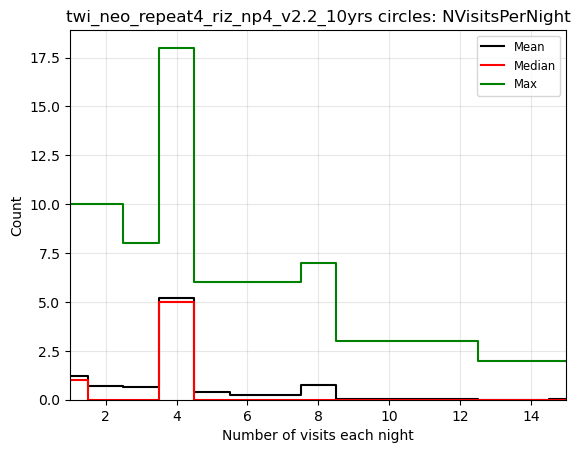

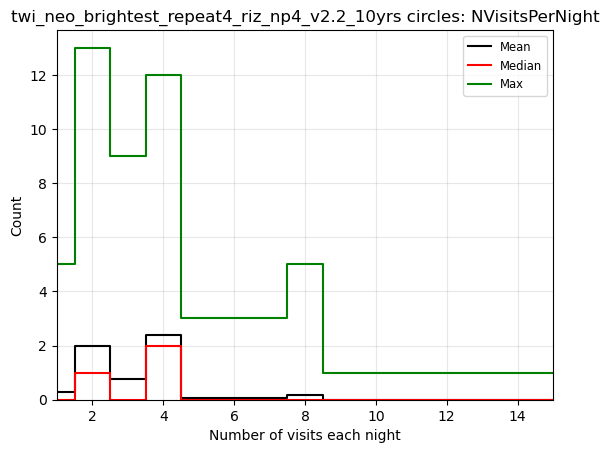

In [25]:
for r in twilights:
    bu = [bundles[r+'_normal'], bundles[r+'_normal'], bundles[r+'_normal']]
    ph.setMetricBundles(bu)
    colors = ['k', 'b', 'c', 'g', 'y', 'r', 'm']
    plotdicts = [{'color': 'k', 'metricReduce': maf.MeanMetric(), 'label': 'Mean'},
                 {'color': 'r', 'metricReduce': maf.MedianMetric(), 'label': 'Median'},
                 {'color': 'g', 'metricReduce': maf.MaxMetric(), 'label': 'Max',
                 'legendlocal': (1.01, 0.2), 'yMin': 0, 'xMin': 1, 'xMax': 15}]
    ph.plot(plotFunc=maf.SummaryHistogram(), plotDicts=plotdicts)

Based on the multiple visits per night using the 'point/small' version of the slicer, we see that the number of visits to a given pointing tends to be 4 times per night (as intended), with only occasional locations with more than 4 (although occasionally over 8). With the 'brightest' twilight NEO run (where the amount of time used for twilight NEO visits is shorter) hardly any locations get more than 4 visits and relatively frequently they only get 2 (although in both cases, most points on the sky get 4 visits in any given twilight period). 

The second plots, with 'circle', include the effects of overlaps and show a wider distribution. 

In [26]:
# useful utilities for the evaluation here ..
def squish_hist(metricValue):
    # Change an array of arrays (dtype=object) to a 2-d array of correct dtype
    mV = np.array(metricValue.compressed().tolist(), dtype=[('metricValue', int)])
    # Make an array to hold the combined result
    finalHist = np.zeros(mV.shape[1], dtype=float)
    # Loop over each bin and use the selected metric to combine the results
    for i in np.arange(finalHist.size):
        finalHist[i] = mV[:, i]['metricValue'].sum()
    return finalHist

def subval_hist(metricValue, i):
    # Pull out the value at one bin
    finalVal = np.zeros(len(metricValue), float)
    for j, (mV, mVmask) in enumerate(zip(metricValue, metricValue.mask)):
        if mVmask:
            finalVal[j] = hp.UNSEEN
        else:
            finalVal[j] = mV[i]
    return finalVal

twi_neo_repeat4_riz_np4_v2.2_10yrs_small 125255.0 21836.0 0.17433236198155763
twi_neo_repeat4_riz_np4_v2.2_10yrs_small 0.8122596663825993 1.0
twi_neo_repeat4_riz_np4_v2.2_10yrs_normal 511182.0 174394.0 0.3411583349961462
twi_neo_repeat4_riz_np4_v2.2_10yrs_normal 0.5802365115131993 0.4
twi_neo_brightest_repeat4_riz_np4_v2.2_10yrs_small 53237.0 165.0 0.003099348197682063
twi_neo_brightest_repeat4_riz_np4_v2.2_10yrs_small 0.9191176470588235 1.0
twi_neo_brightest_repeat4_riz_np4_v2.2_10yrs_normal 232363.0 34571.0 0.1487801414166627
twi_neo_brightest_repeat4_riz_np4_v2.2_10yrs_normal 0.5492835312477738 0.4


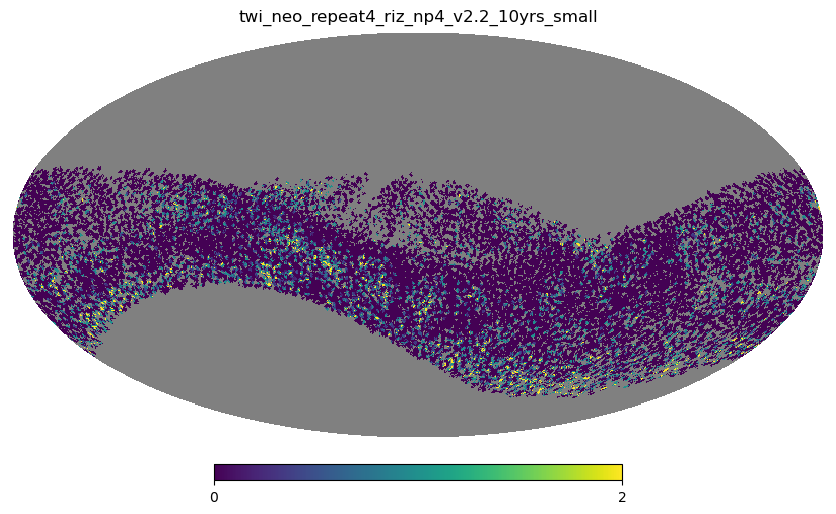

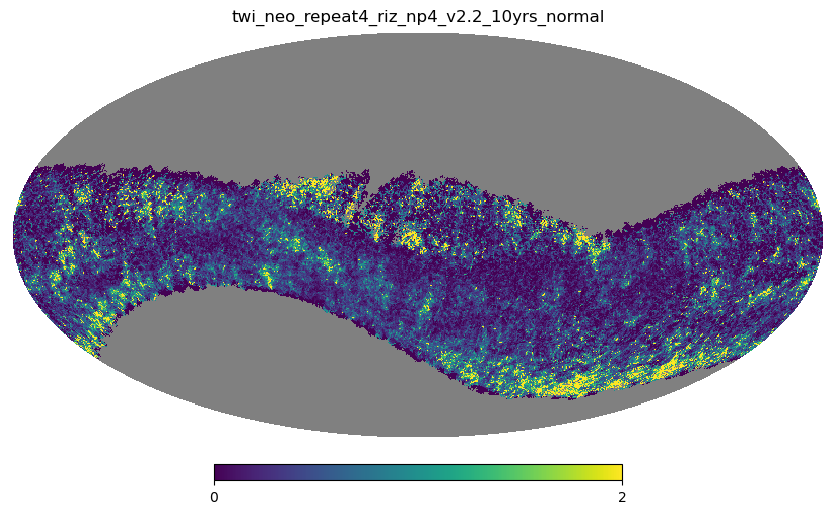

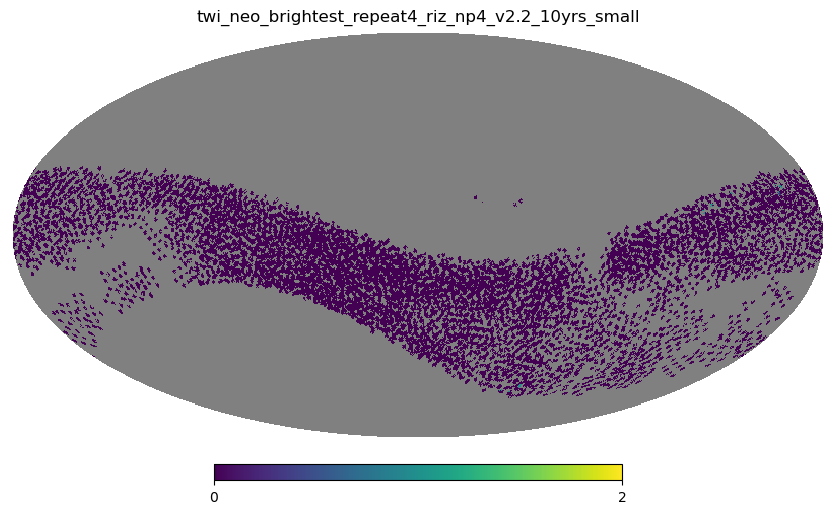

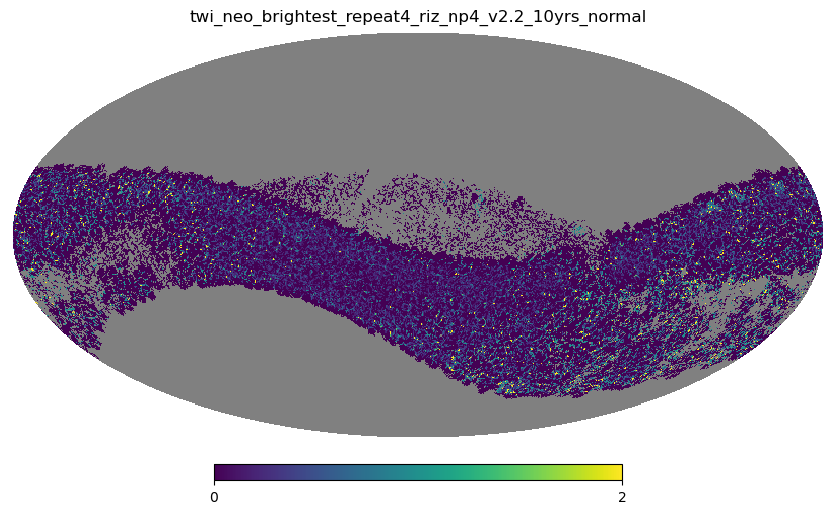

In [45]:
for r in twilights:
    for t in ['_small', '_normal']:
        # nights with N=4 visits
        v = subval_hist(bundles[r+t].metricValues, 3)
        a = np.where(v>0, v, 0)
        # nights with >4 visits
        v = subval_hist(bundles[r+t].metricValues, 4)
        for i in np.arange(5, len(countbins)-1):
            v += subval_hist(bundles[r+t].metricValues, i)
        b = np.where(v>0, v, 0)                       
        print(r+t, a.sum(), b.sum(), b.sum()/a.sum())
        ratio = np.where(a > 0, b/a, hp.UNSEEN)
        hp.mollview(ratio, min=0, max=2, title=r+t)
        print(r+t, np.mean(ratio[np.where(ratio>0)]), np.median(ratio[np.where(ratio>0)]))

From these estimates of how many nights receive >4 visits vs. how many nights receive only 4 visits, it looks like we're hitting the goal of almost every time getting about 4 visits and not more. 

### Impact/Benefits

In [46]:
# Summary metrics relating to solar system objects
twilight_runs = families.explode('run').loc['twilight neo 15s']['run']
d = summaries.loc[twilight_runs]
d

metric                                        fOArea fO  HealpixSlicer  \
run                                                                      
twi_neo_brightest_repeat3_z_np4_v2.2_10yrs                 9119.764749   
twi_neo_brightest_repeat3_z_np7_v2.2_10yrs                 8558.277300   
twi_neo_brightest_repeat3_z_np3_v2.2_10yrs                 8528.062729   
twi_neo_repeat3_z_np4_v2.2_10yrs                           7668.626036   
twi_neo_brightest_repeat3_z_np6_v2.2_10yrs                 7615.750537   
...                                                                ...   
twi_neo_repeat4_riz_np6_v2.2_10yrs                         2186.359946   
twi_neo_repeat4_riz_np5_v2.2_10yrs                         1549.336069   
twi_neo_repeat4_riz_np2_v2.2_10yrs                         1577.032759   
twi_neo_repeat4_riz_np1_v2.2_10yrs                          134.286983   
twi_neo_brightest_repeat4_riz_np1_v2.2_10yrs               1117.099842   

metric                                        fOArea/benchmark fO  HealpixSlicer  \
run                                                                                
twi_neo_brightest_repeat3_z_np4_v2.2_10yrs                              0.506654   
twi_neo_brightest_repeat3_z_np7_v2.2_10yrs                              0.475460   
twi_neo_brightest_repeat3_z_np3_v2.2_10yrs                              0.473781   
twi_neo_repeat3_z_np4_v2.2_10yrs                                        0.426035   
twi_neo_brightest_repeat3_z_np6_v2.2_10yrs                              0.423097   
...                                                                          ...   
twi_neo_repeat4_riz_np6_v2.2_10yrs                                      0.121464   
twi_neo_repeat4_riz_np5_v2.2_10yrs                                      0.086074   
twi_neo_repeat4_riz_np2_v2.2_10yrs                                      0.087613   
twi_neo_repeat4_riz_np1_v2.2_10yrs                                      0.007460   
twi_neo_brightest_repeat4_riz_np1_v2.2_10yrs                            0.062061   

metric                                        fONv MedianNvis fO  HealpixSlicer  \
run                                                                               
twi_neo_brightest_repeat3_z_np4_v2.2_10yrs                                825.0   
twi_neo_brightest_repeat3_z_np7_v2.2_10yrs                                823.0   
twi_neo_brightest_repeat3_z_np3_v2.2_10yrs                                823.0   
twi_neo_repeat3_z_np4_v2.2_10yrs                                          820.0   
twi_neo_brightest_repeat3_z_np6_v2.2_10yrs                                819.0   
...                                                                         ...   
twi_neo_repeat4_riz_np6_v2.2_10yrs                                        793.0   
twi_neo_repeat4_riz_np5_v2.2_10yrs                                        788.0   
twi_neo_repeat4_riz_np2_v2.2_10yrs                                        787.0   
twi_neo_repeat4_riz_np1_v2.2_10yrs                                        744.0   
twi_neo_brightest_repeat4_riz_np1_v2.2_10yrs                              783.0   

metric                                        fONv MinNvis fO  HealpixSlicer  \
run                                                                            
twi_neo_brightest_repeat3_z_np4_v2.2_10yrs                             774.0   
twi_neo_brightest_repeat3_z_np7_v2.2_10yrs                             773.0   
twi_neo_brightest_repeat3_z_np3_v2.2_10yrs                             772.0   
twi_neo_repeat3_z_np4_v2.2_10yrs                                       769.0   
twi_neo_brightest_repeat3_z_np6_v2.2_10yrs                             769.0   
...                                                                      ...   
twi_neo_repeat4_riz_np6_v2.2_10yrs                                     744.0   
twi_neo_repeat4_riz_np5_v2.2_10yrs                                     738.0   
twi_neo_repeat4_riz_np2_v2.2_10yrs                              

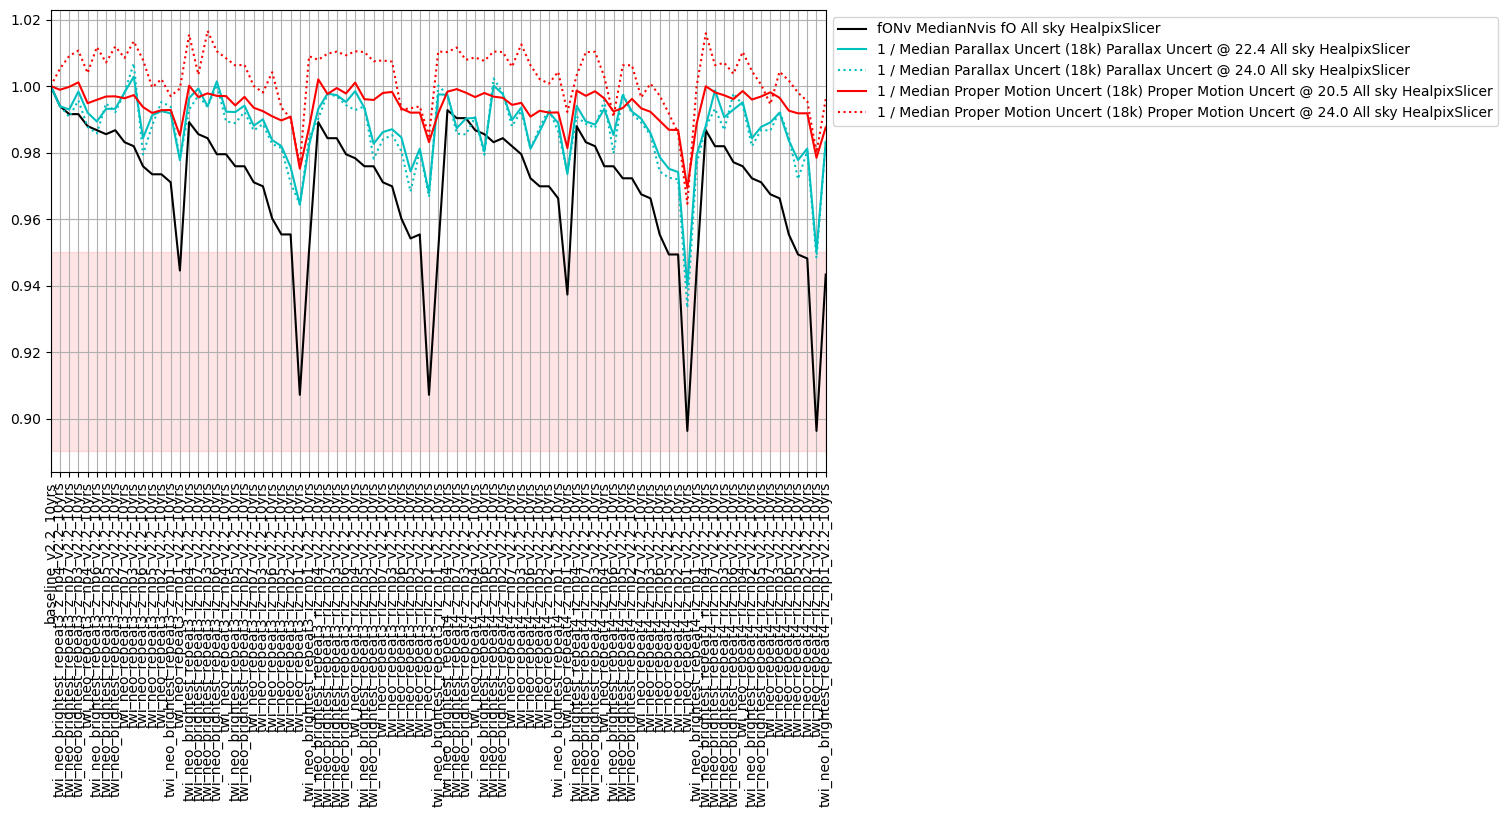

In [55]:
# Impact to SRD metrics (a good place to start in overall impact to other science goals)
mset = metric_sets.loc['SRD']
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, mset['metric']],
                             baseline_run=baseline_run,
                             metric_set=mset,
                             horizontal_quantity='run',
                             vertical_quantity='value')

In [64]:
t = summaries.loc[these_runs].sort_values('fONv MedianNvis fO All sky HealpixSlicer').copy()
list(t.index)

['twi_neo_repeat4_iz_np1_v2.2_10yrs',
 'twi_neo_repeat4_riz_np1_v2.2_10yrs',
 'twi_neo_repeat3_riz_np1_v2.2_10yrs',
 'twi_neo_repeat3_iz_np1_v2.2_10yrs',
 'twi_neo_repeat4_z_np1_v2.2_10yrs',
 'twi_neo_brightest_repeat4_riz_np1_v2.2_10yrs',
 'twi_neo_brightest_repeat4_iz_np1_v2.2_10yrs',
 'twi_neo_repeat3_z_np1_v2.2_10yrs',
 'twi_neo_repeat4_riz_np2_v2.2_10yrs',
 'twi_neo_repeat4_riz_np5_v2.2_10yrs',
 'twi_neo_repeat4_iz_np2_v2.2_10yrs',
 'twi_neo_repeat4_iz_np5_v2.2_10yrs',
 'twi_neo_brightest_repeat3_iz_np1_v2.2_10yrs',
 'twi_neo_brightest_repeat3_riz_np1_v2.2_10yrs',
 'twi_neo_repeat3_riz_np5_v2.2_10yrs',
 'twi_neo_repeat3_iz_np5_v2.2_10yrs',
 'twi_neo_repeat4_riz_np6_v2.2_10yrs',
 'twi_neo_repeat3_riz_np2_v2.2_10yrs',
 'twi_neo_repeat4_iz_np6_v2.2_10yrs',
 'twi_neo_repeat3_iz_np2_v2.2_10yrs',
 'twi_neo_repeat3_iz_np6_v2.2_10yrs',
 'twi_neo_repeat3_riz_np6_v2.2_10yrs',
 'twi_neo_brightest_repeat4_z_np1_v2.2_10yrs',
 'twi_neo_repeat4_iz_np3_v2.2_10yrs',
 'twi_neo_repeat4_riz_np3_v2.2_

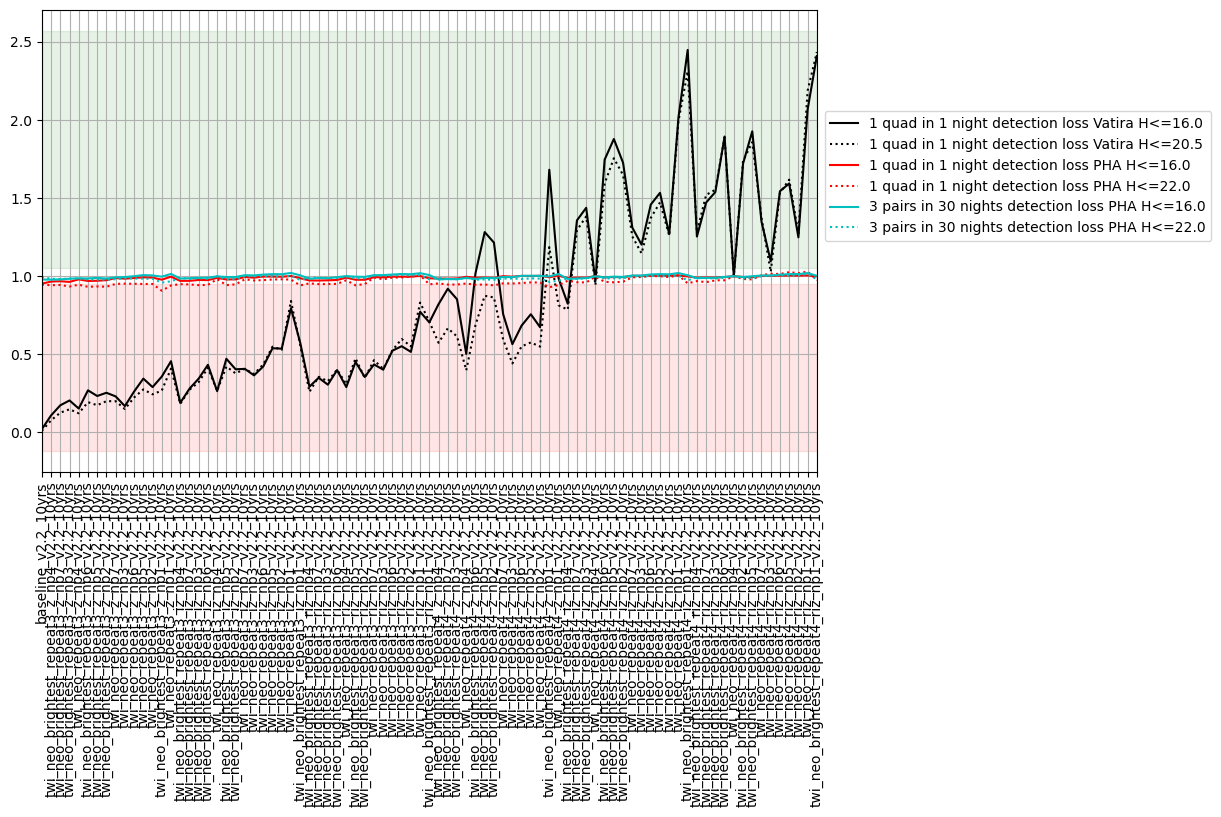

In [65]:
metrics = ['1 quad in 1 night detection loss Vatira H<=16.0',
            '1 quad in 1 night detection loss Vatira H<=20.5',
           '1 quad in 1 night detection loss PHA H<=16.0',
            '1 quad in 1 night detection loss PHA H<=22.0',
           '3 pairs in 30 nights detection loss PHA H<=16.0',
             '3 pairs in 30 nights detection loss PHA H<=22.0'
          ]
short_names = [m.replace(' detection loss', '') for m in metrics]
styles = ['k-', 'k:', 'r-', 'r:', 'c-', 'c:']
mset = maf.create_metric_set_df('vatira', metrics, short_names, style=styles)
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metrics],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                             horizontal_quantity='run',
                             vertical_quantity='value')
#for l in lines:
#    plt.axvline(l, color='k', alpha=0.3)

lgd = plt.legend(loc=(1.01, 0.5), fancybox=True, numpoints=1, fontsize='medium')
fig.set_figwidth(10)


In [69]:
sso_sets = [m for m in metric_sets.groupby('metric set').first().index if 'SSO' in m and 'DDF' not in m]
sso_sets

['SSO N Objs',
 'SSO discovery',
 'SSO discovery options',
 'SSO fraction 3 bands',
 'SSO fraction 4 bands',
 'SSO fraction 5 bands',
 'SSO fraction 6 bands',
 'SSO lightcurve inversion']

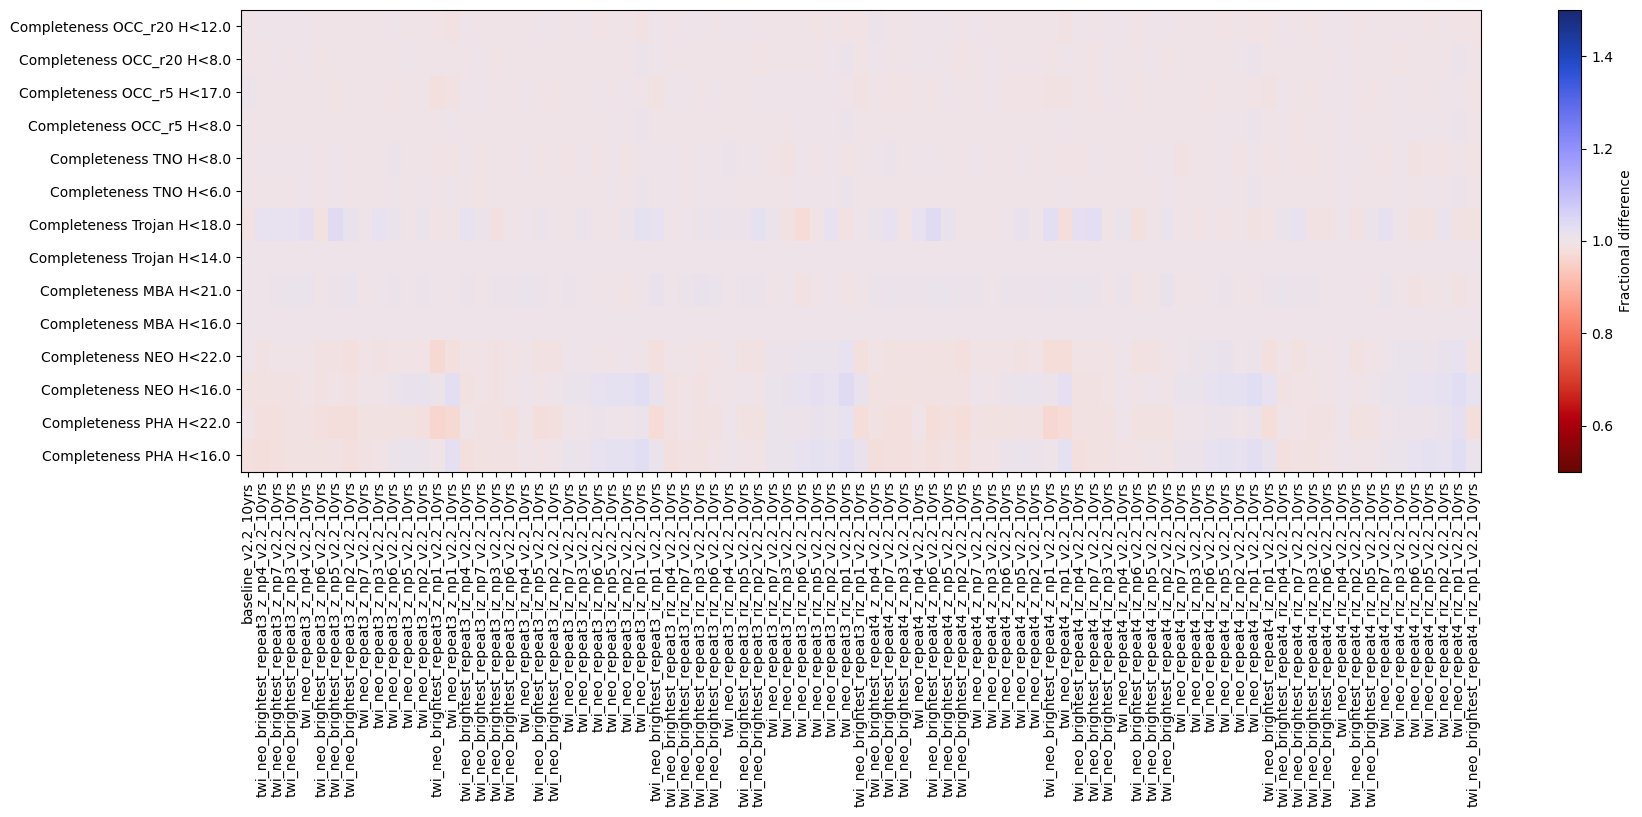

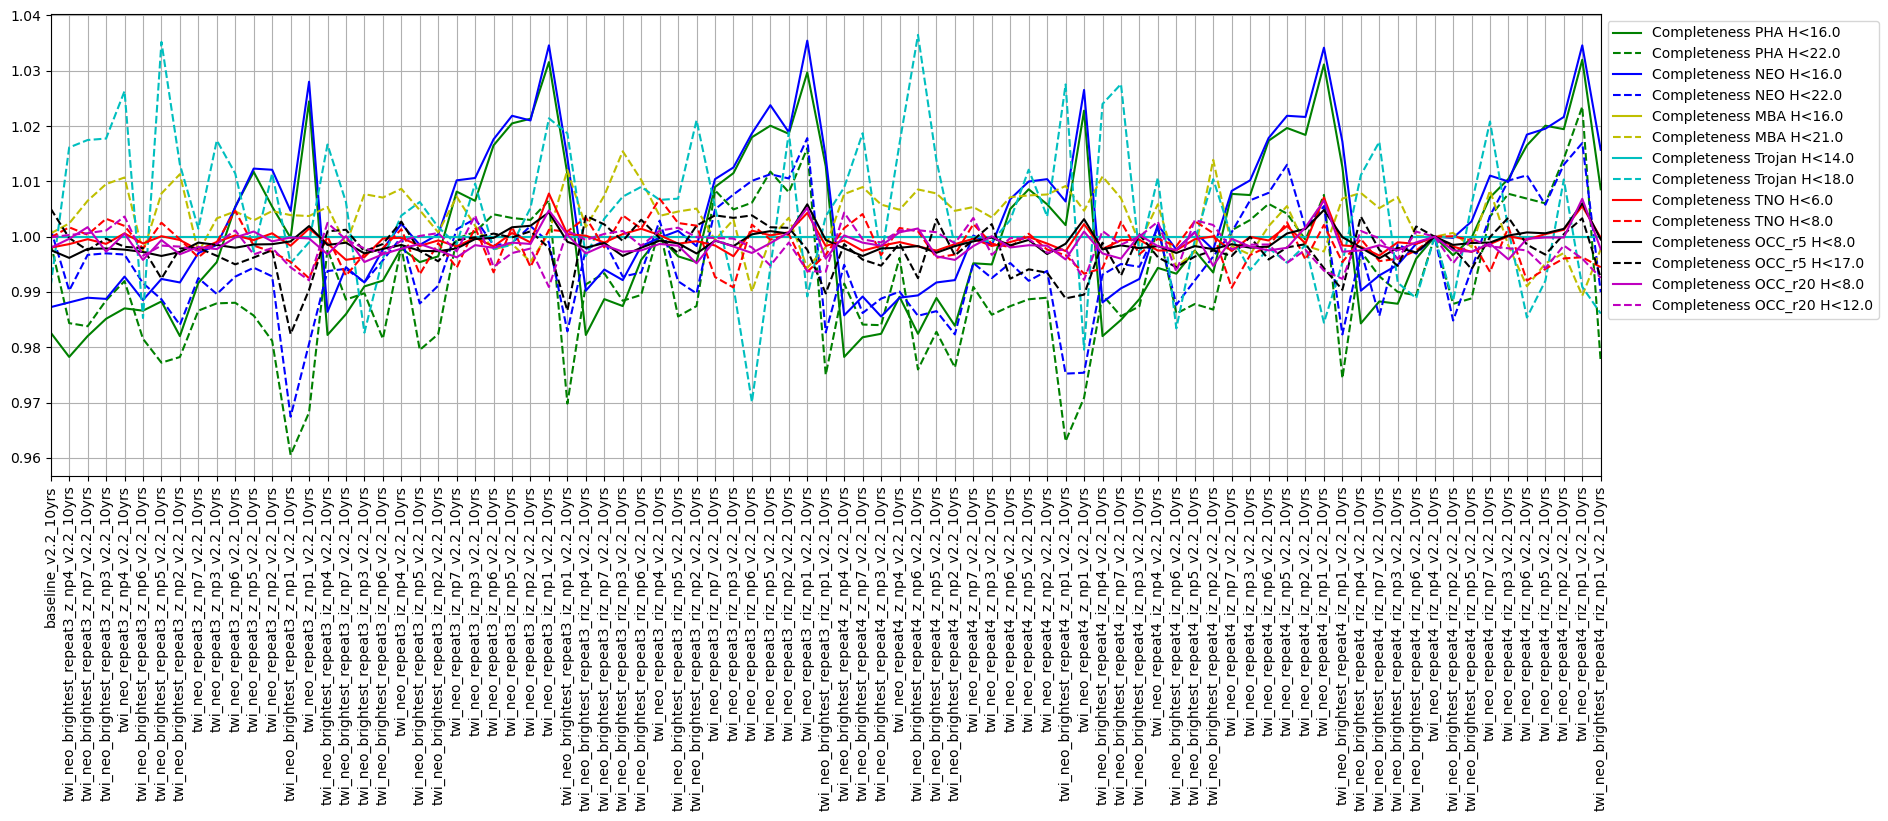

In [76]:
mset = metric_sets.loc['SSO discovery']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'])
fig.set_figwidth(20)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)

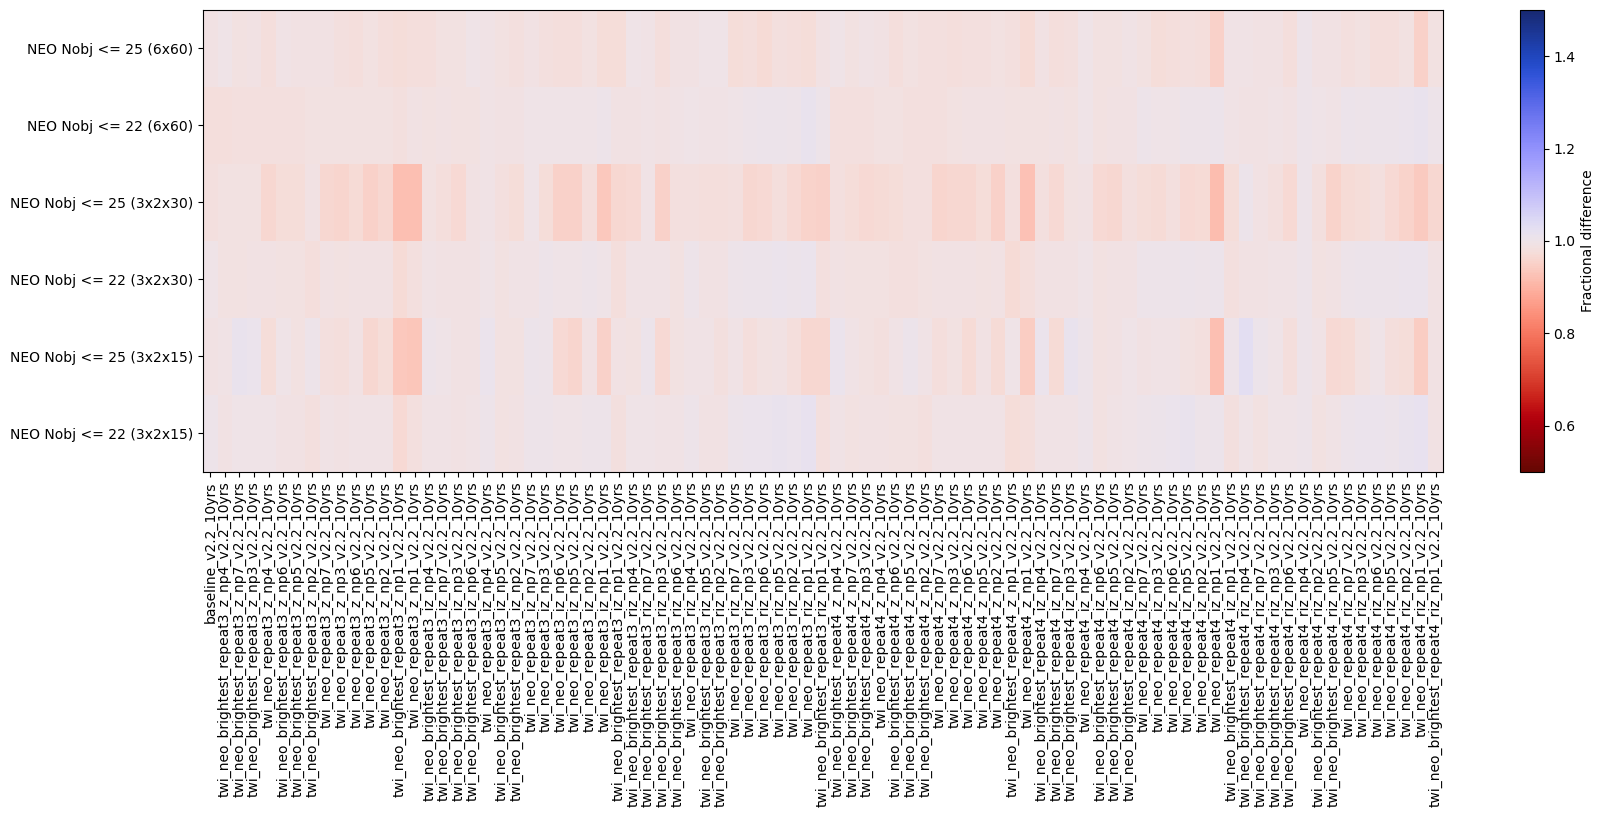

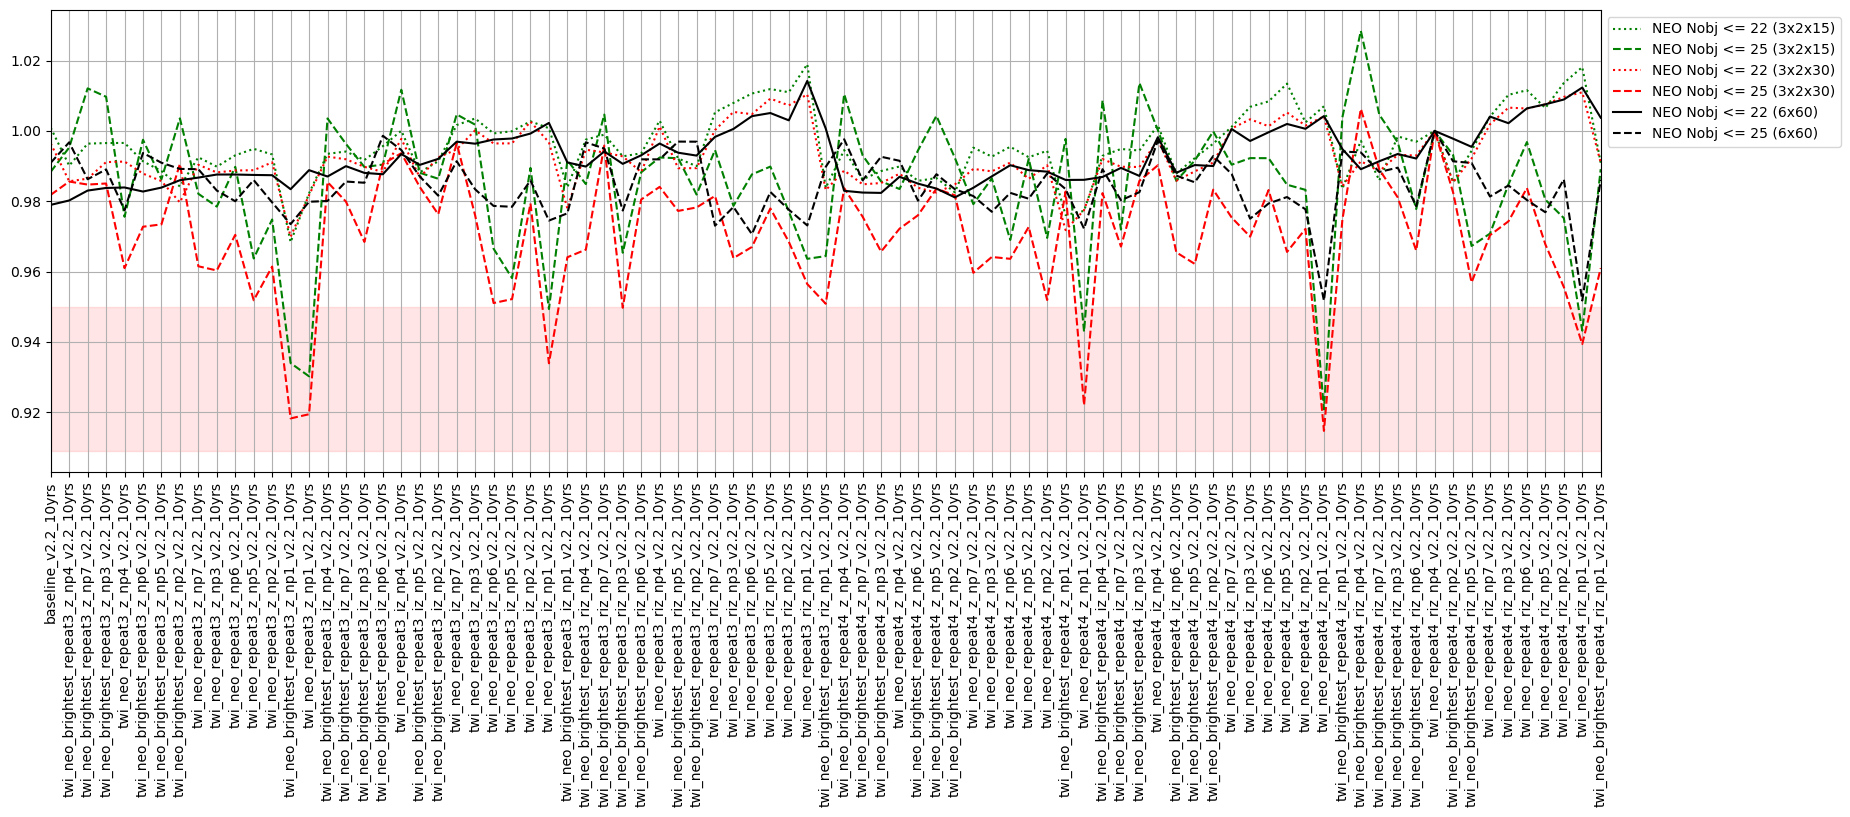

In [79]:
mset = metric_sets.loc['SSO N Objs']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'])
fig.set_figwidth(20)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)

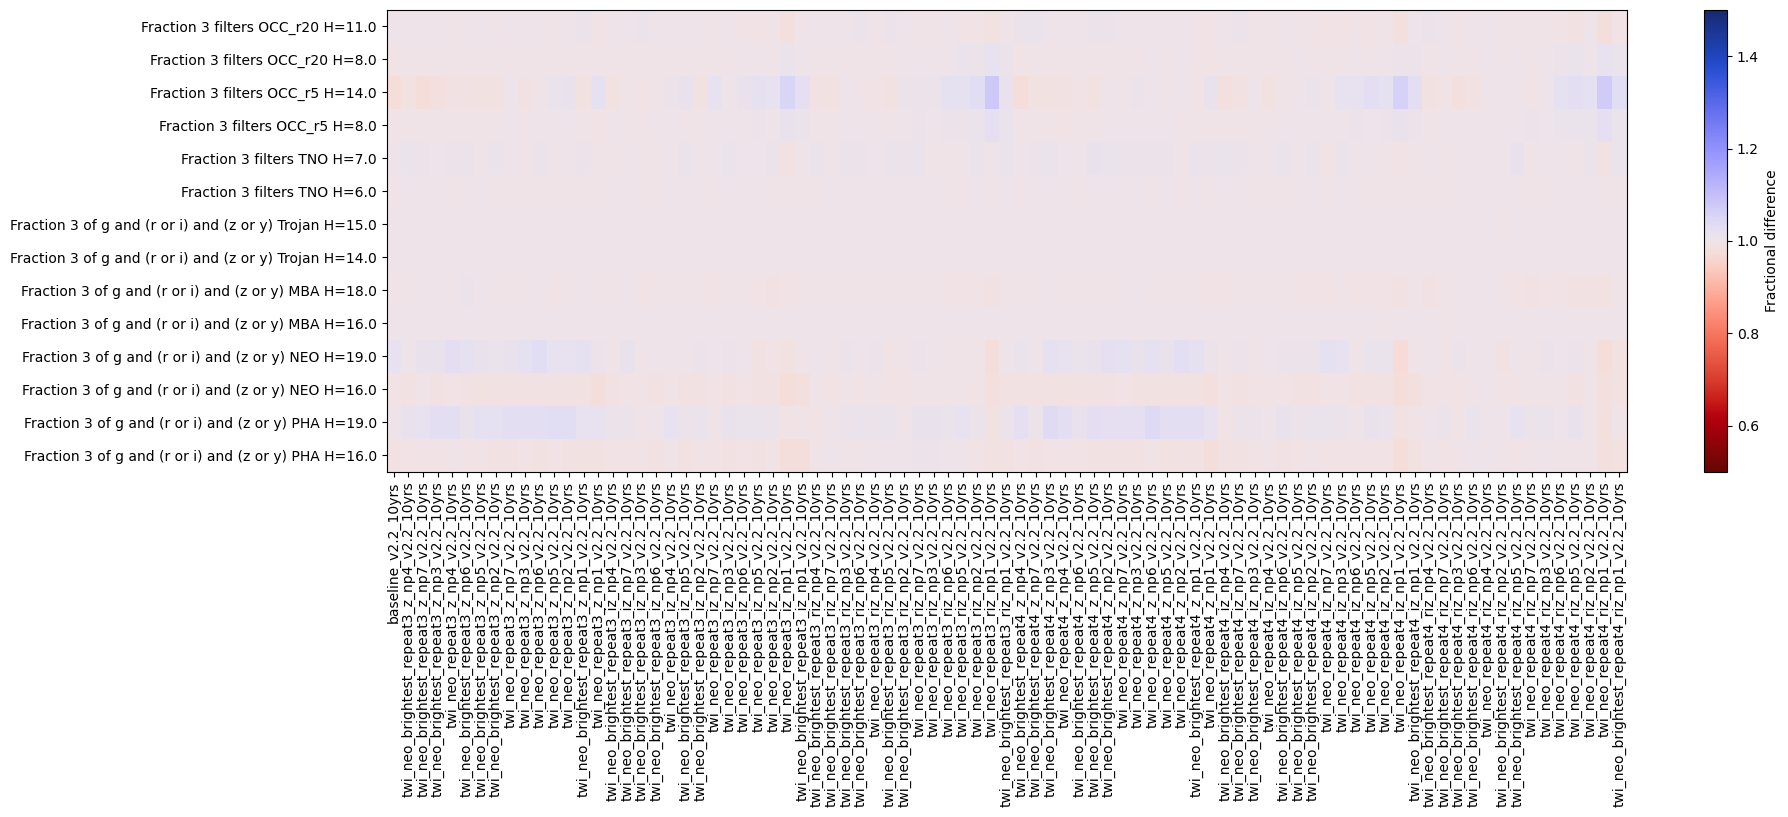

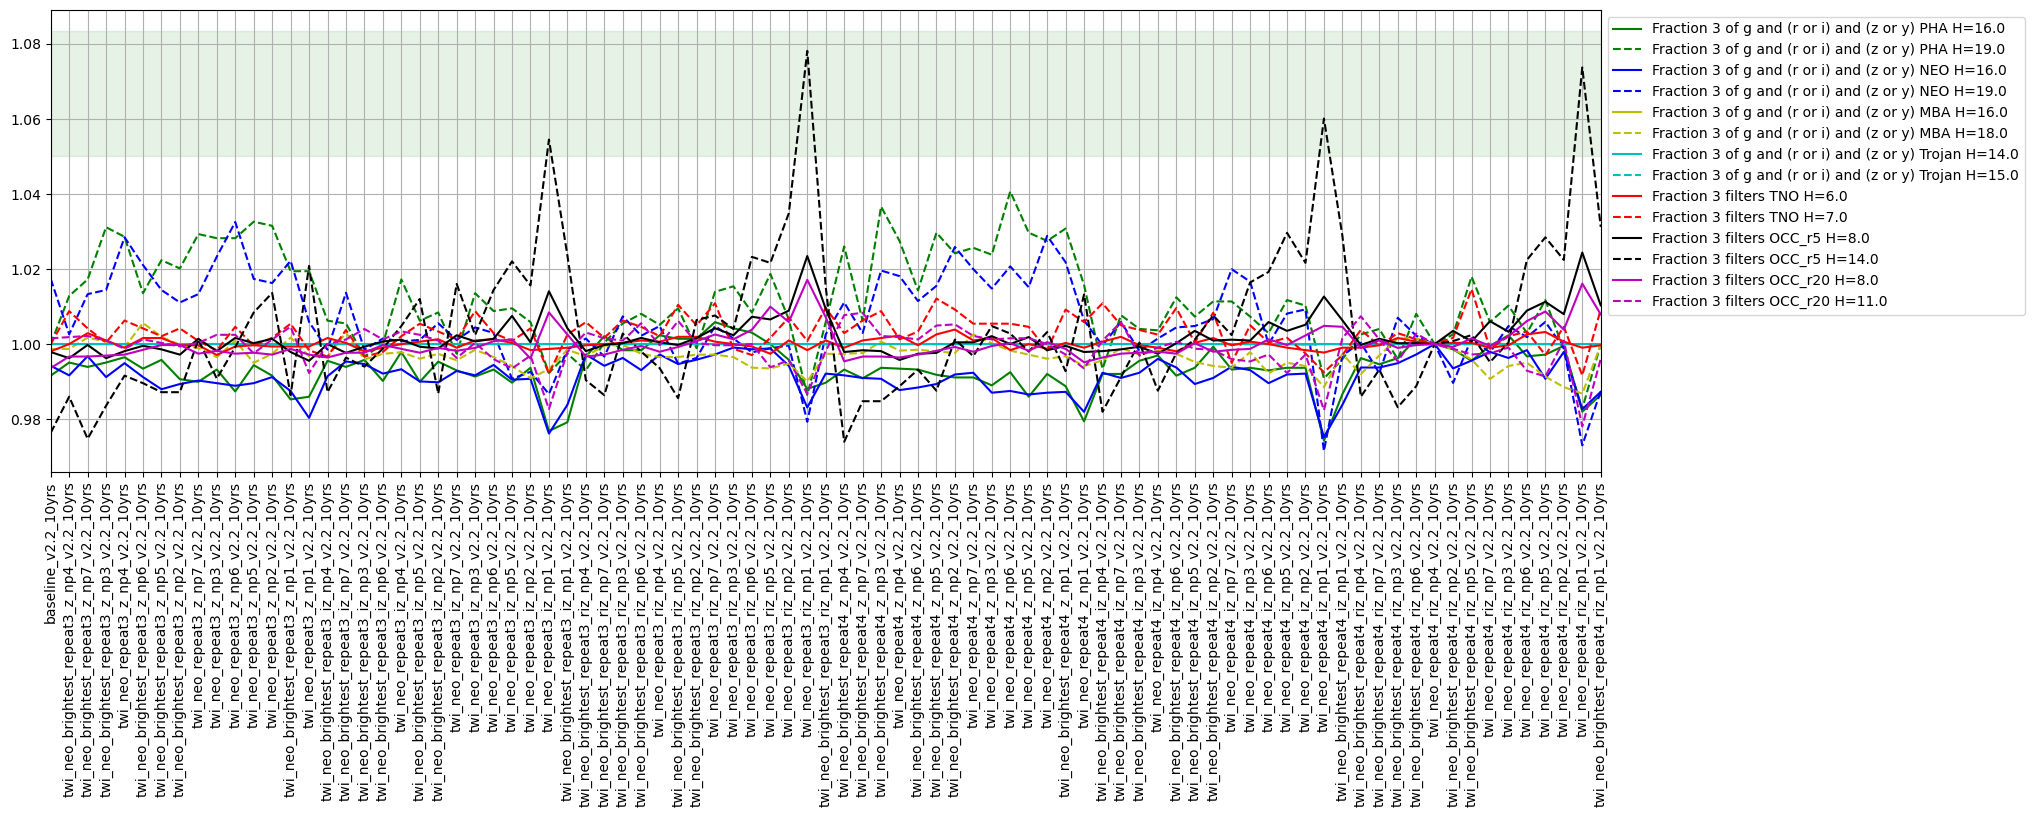

In [81]:
mset = metric_sets.loc['SSO fraction 3 bands']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'])
fig.set_figwidth(20)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)

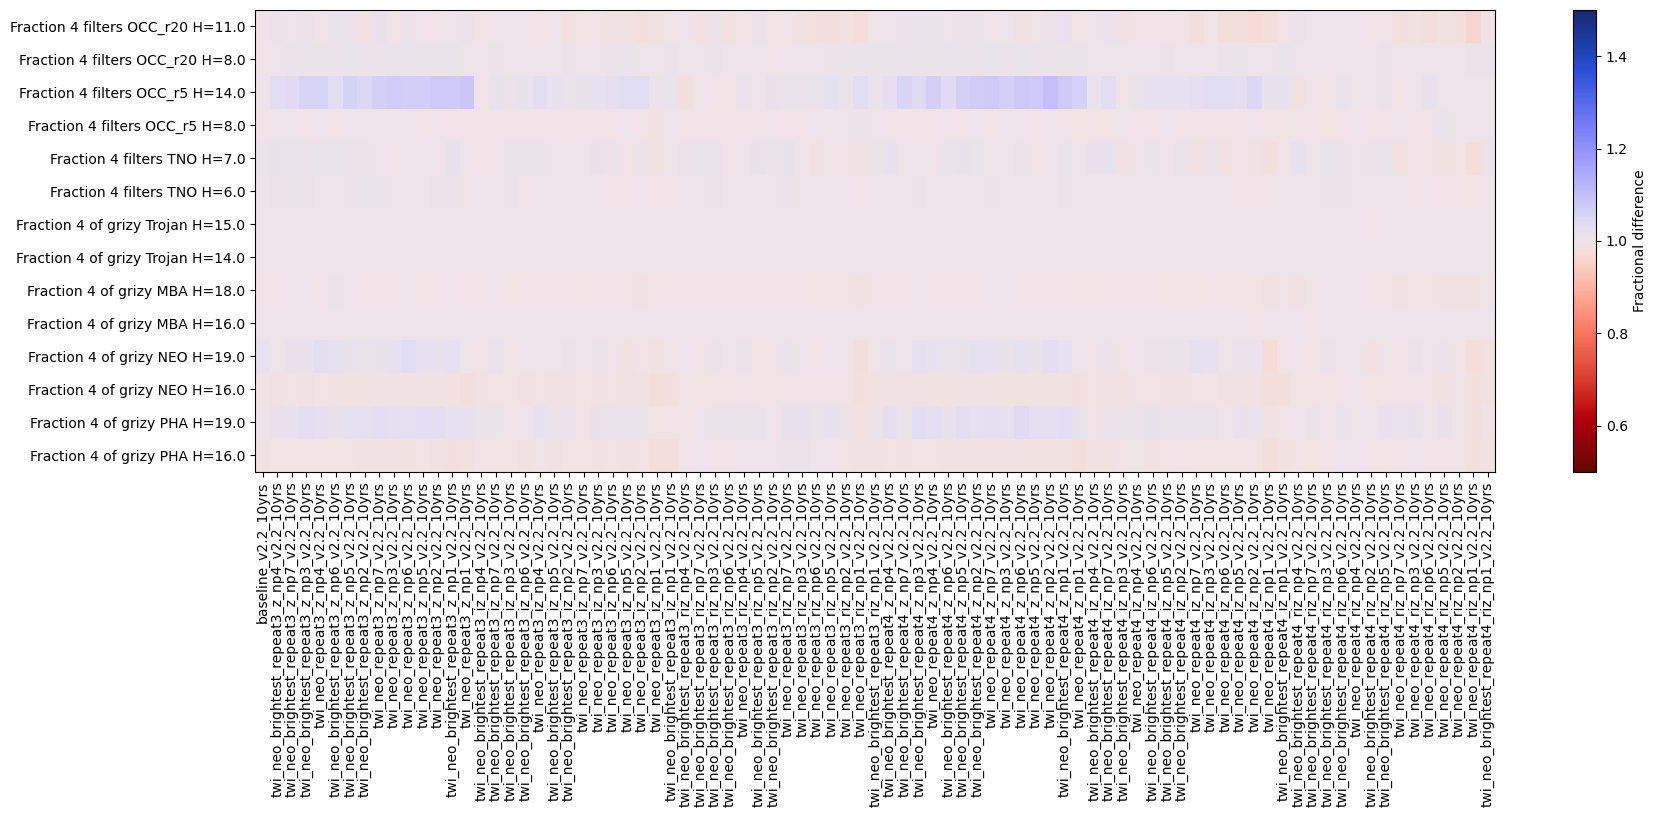

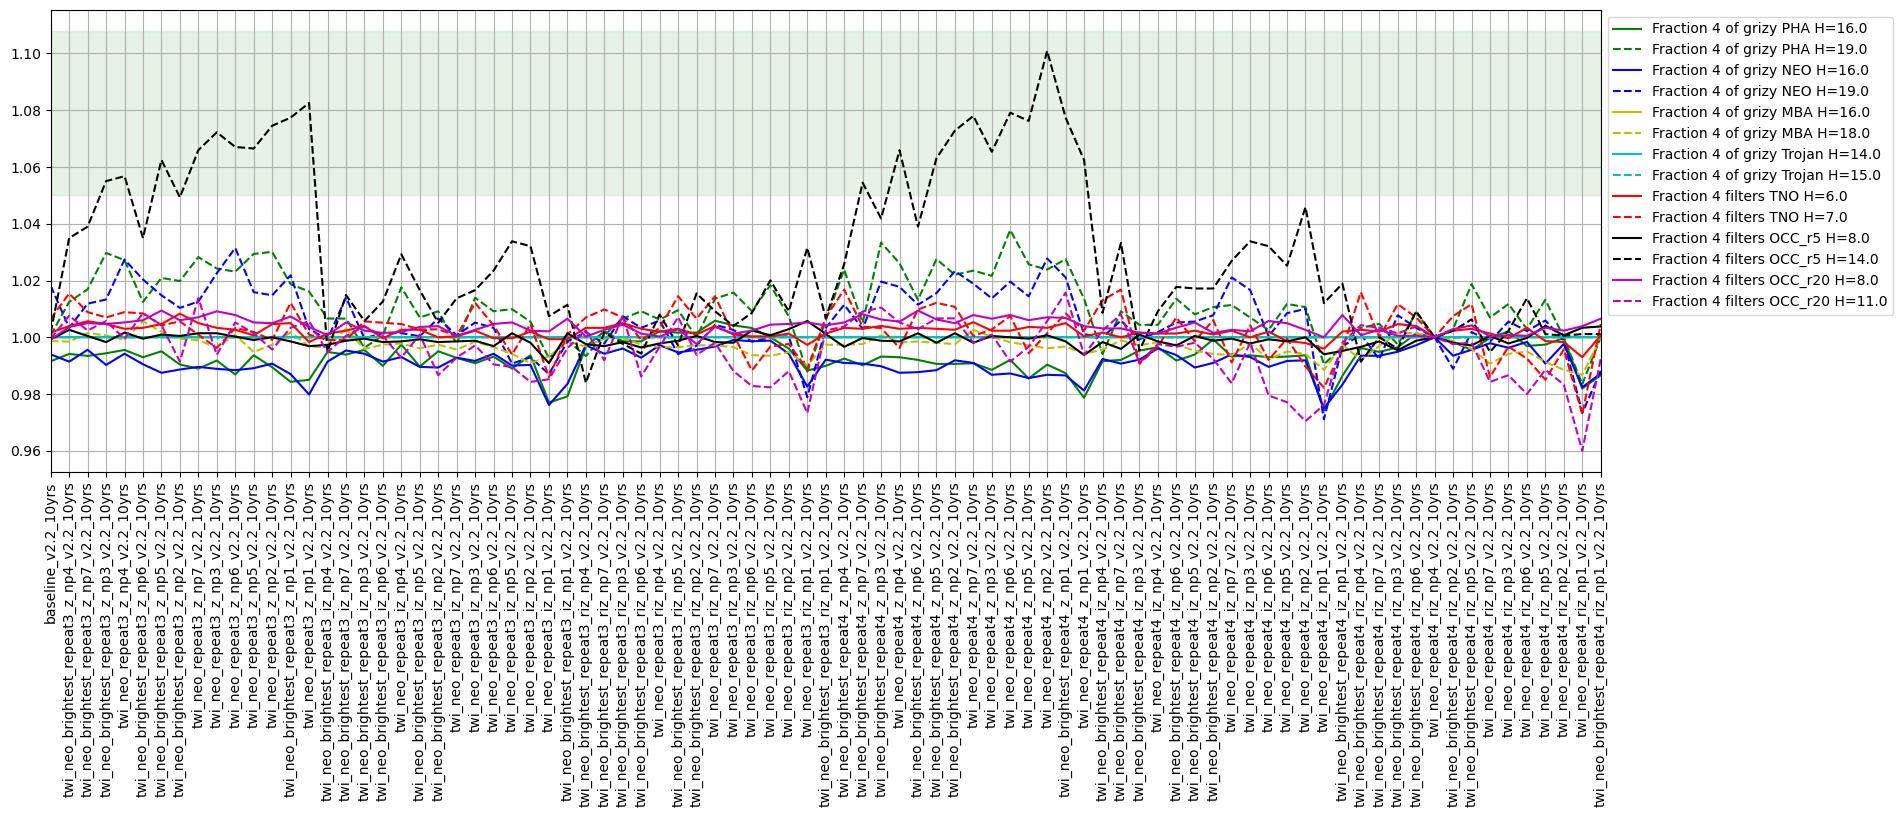

In [82]:
mset = metric_sets.loc['SSO fraction 4 bands']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'])
fig.set_figwidth(20)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)

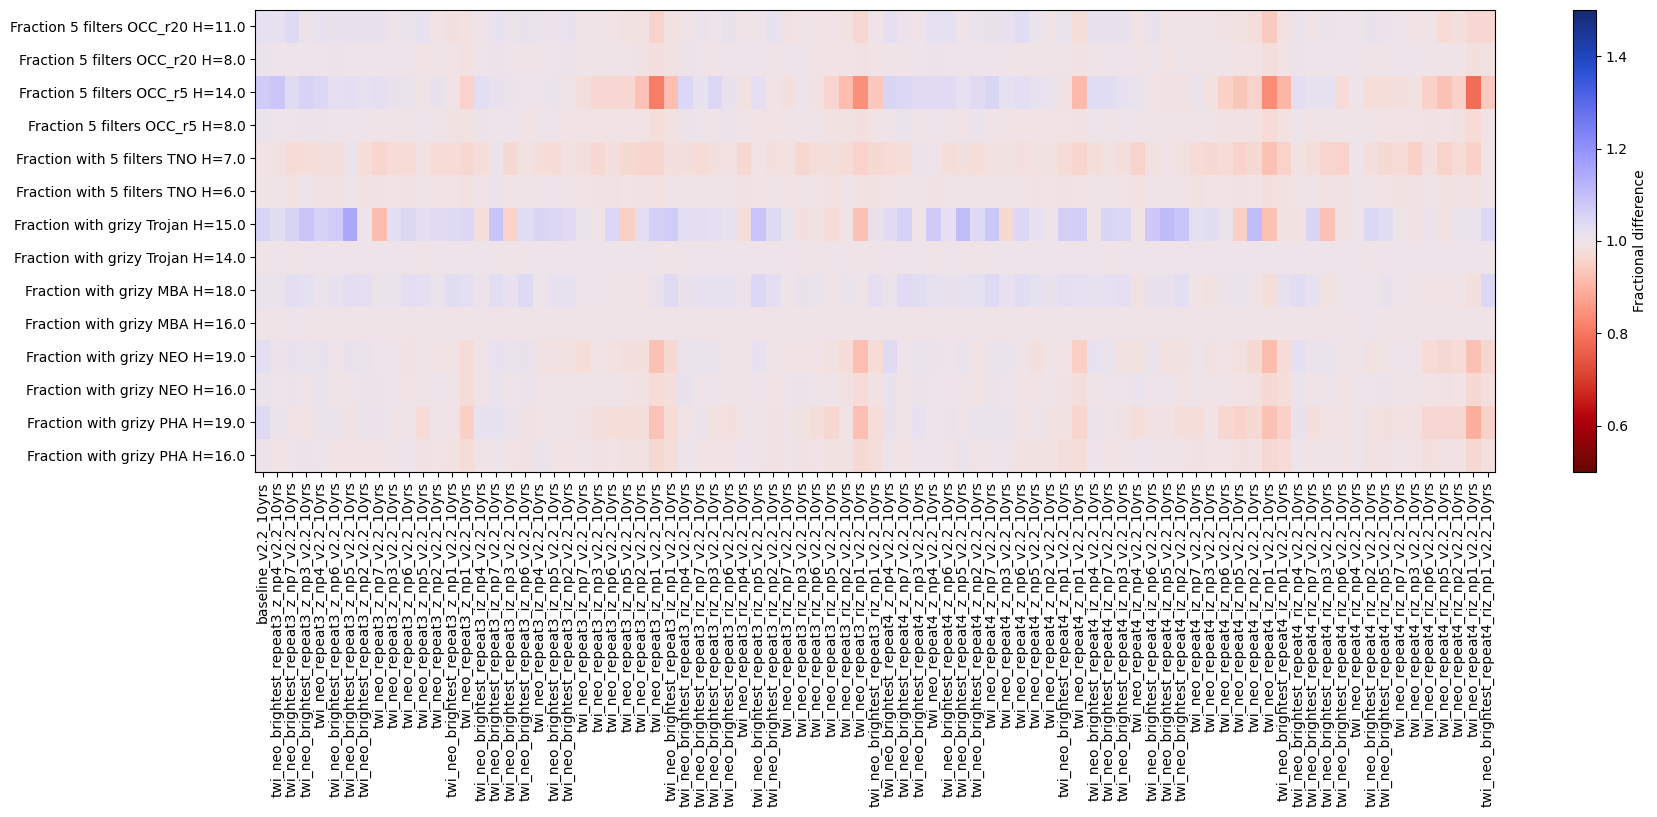

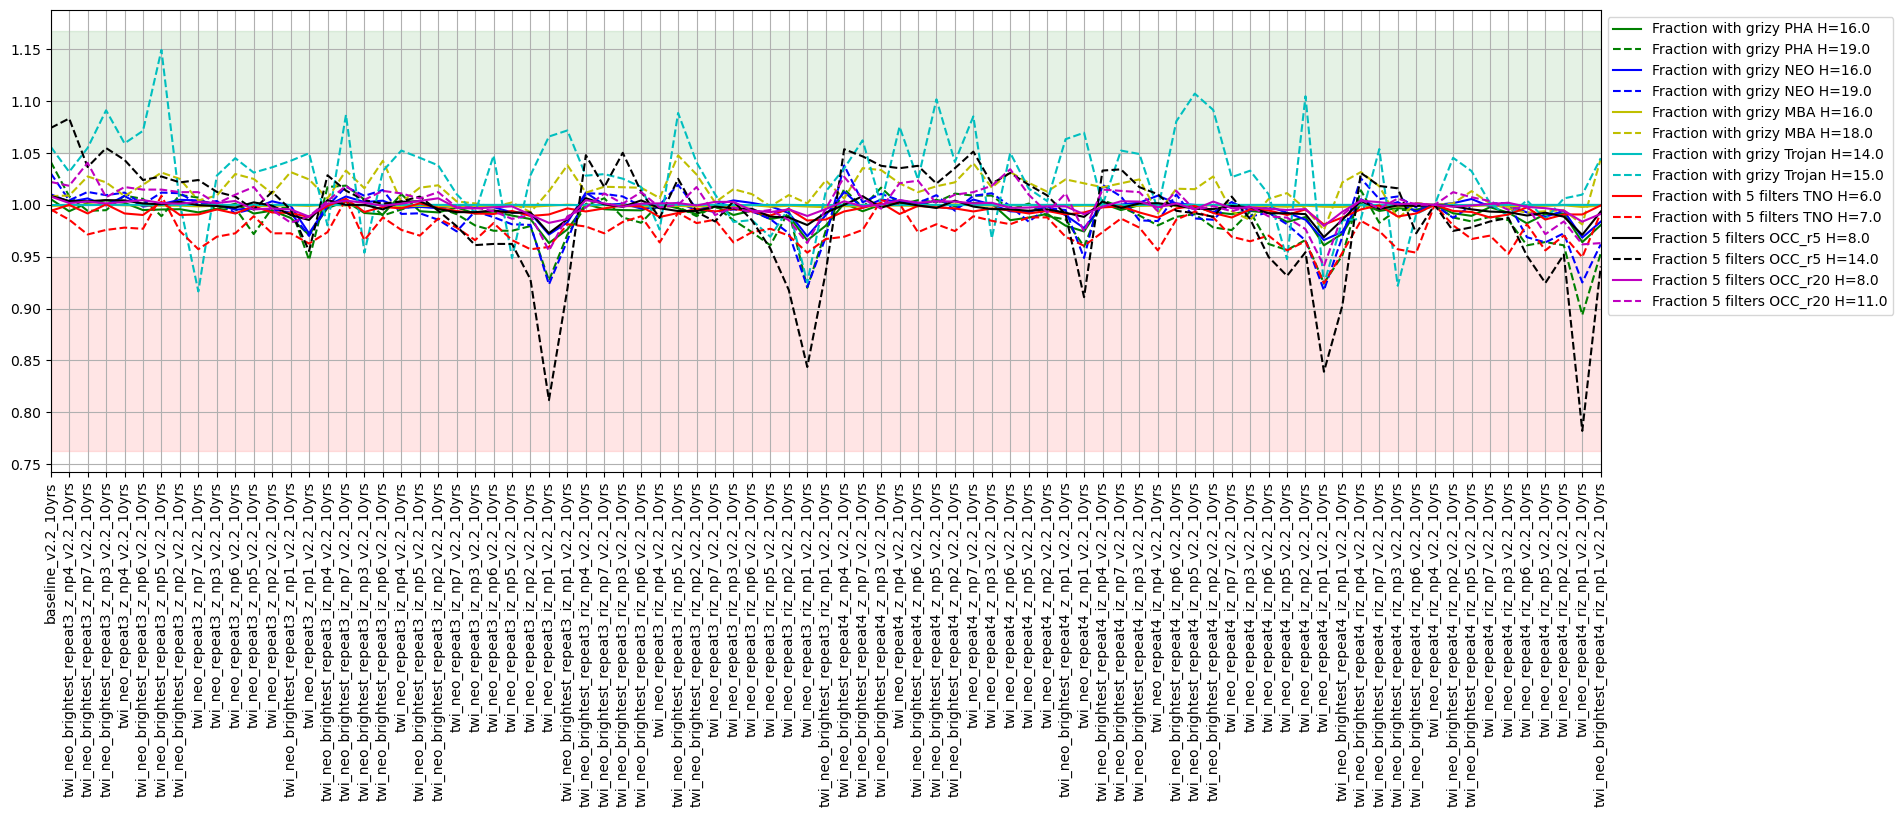

In [83]:
mset = metric_sets.loc['SSO fraction 5 bands']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'])
fig.set_figwidth(20)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)

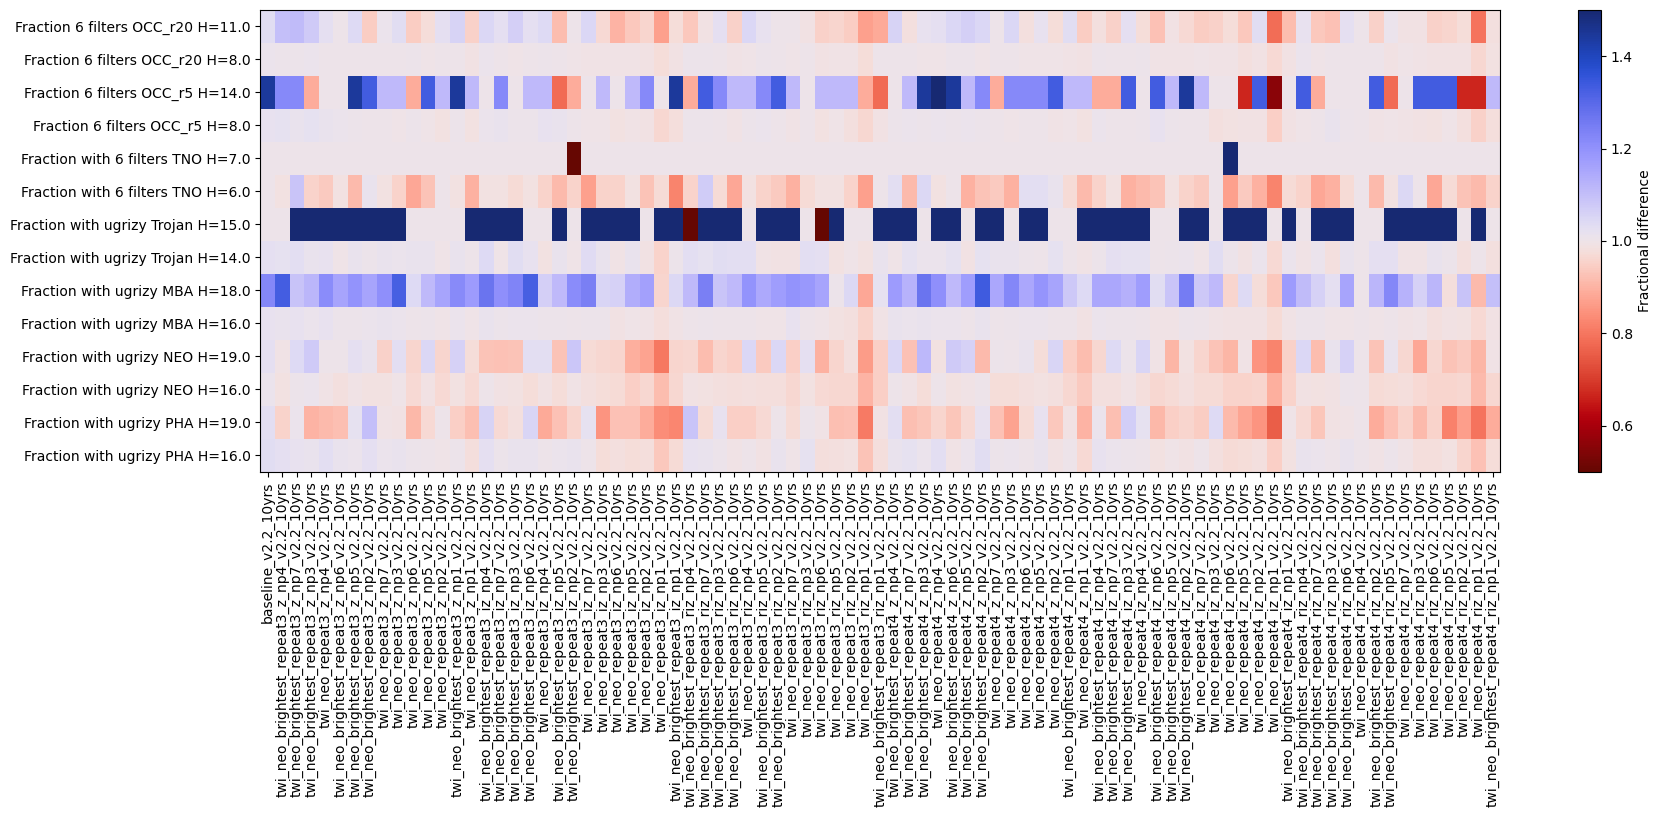

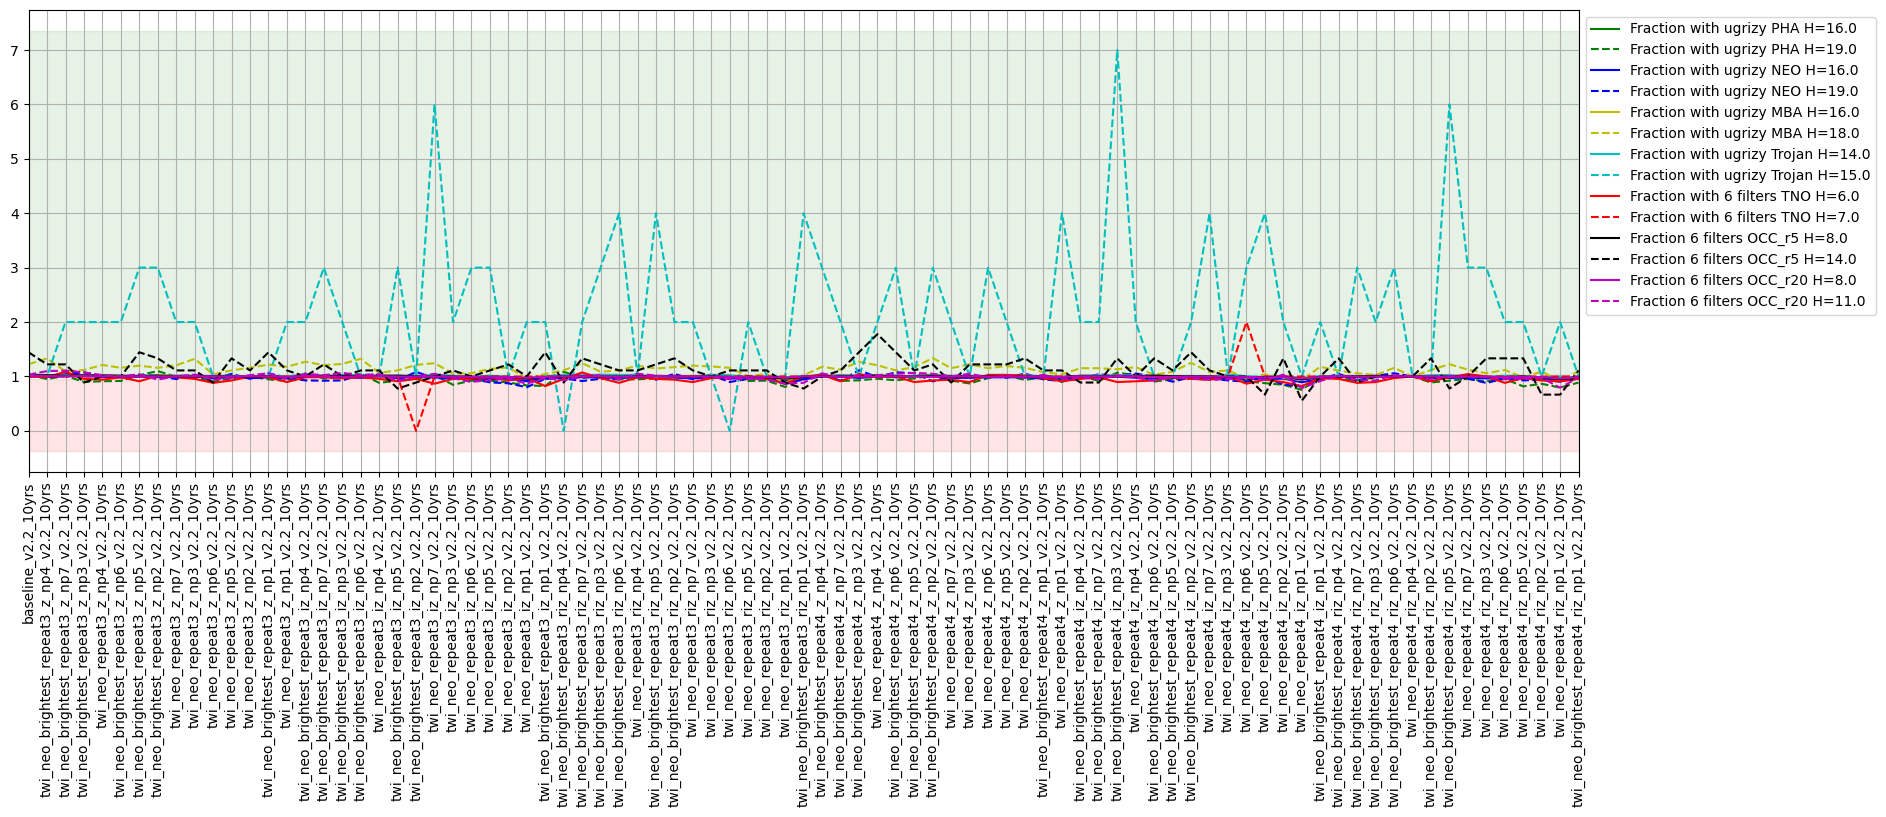

In [84]:
mset = metric_sets.loc['SSO fraction 6 bands']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'])
fig.set_figwidth(20)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)

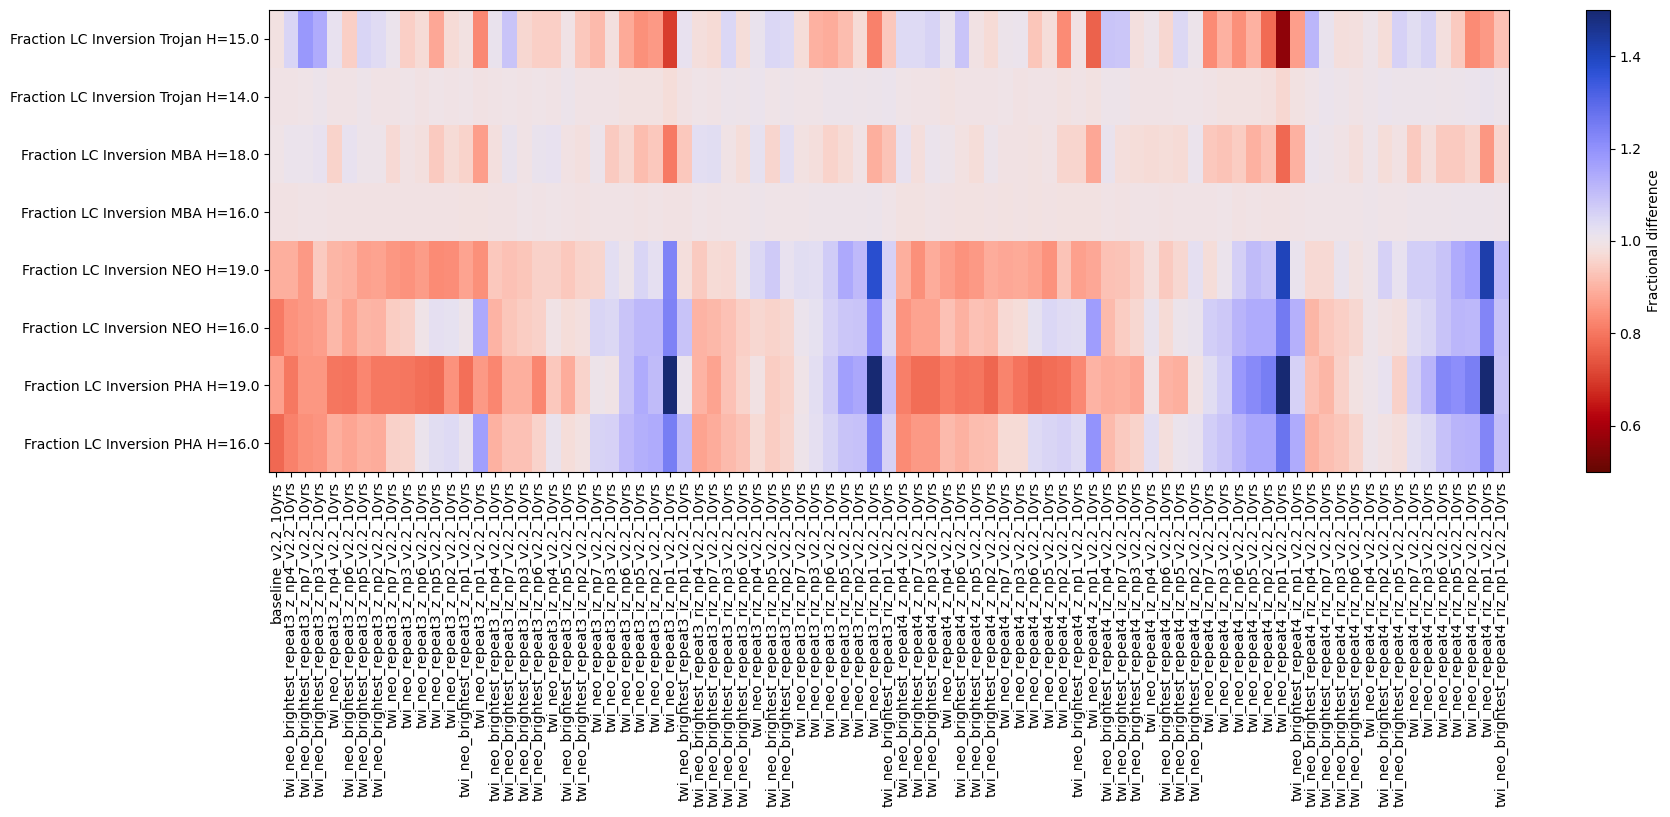

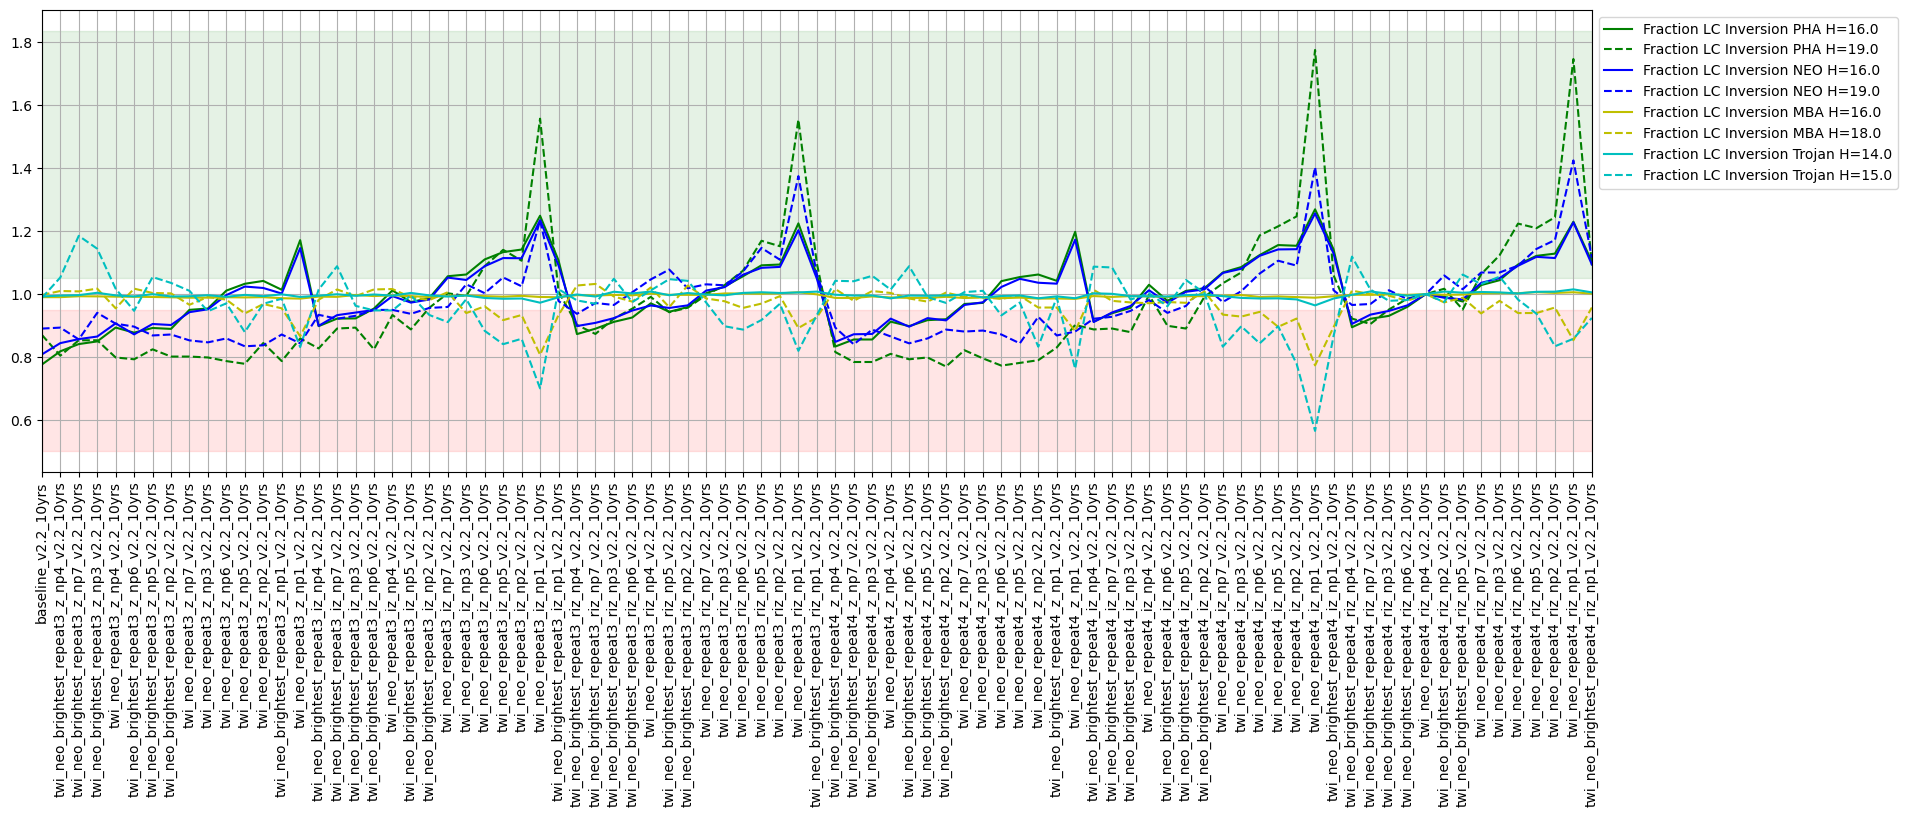

In [85]:
mset = metric_sets.loc['SSO lightcurve inversion']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'])
fig.set_figwidth(20)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, mset['metric']],
                             baseline_run='twi_neo_repeat4_riz_np4_v2.2_10yrs',
                             metric_set=mset,
                                metric_label_map=mset['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(20)

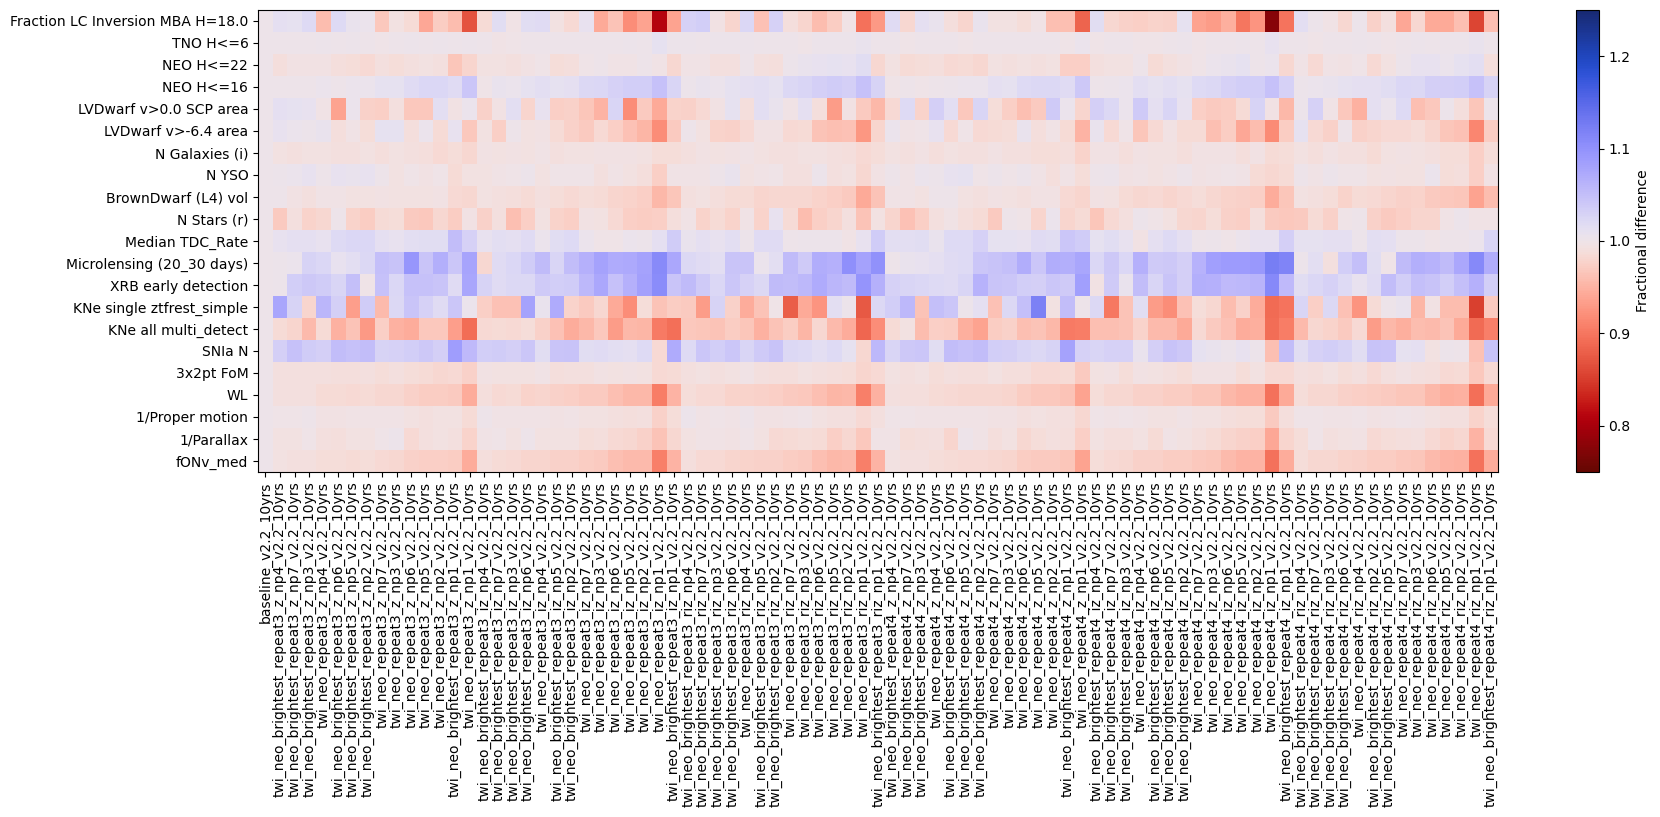

In [89]:
msub = metric_sets.loc['SCOC']

lines =  np.arange(0, 7, 1) * 7 + 1
lines = np.concatenate([[1], lines])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']],
                        baseline_run=baseline_run,
                        metric_set=msub,
                                  metric_label_map=msub['short_name'],
                                  color_range=0.5)

fig.set_figwidth(20)